# **1. DATA UNDERSTANDING**

## **Context**

`northwind` database is a sample database that is provided by Microsoft to demonstrate the features of some of its products. The `northwind` database contains sales data for a fictitious company called *Northwind Traders*, which imports and exports specialty foods from around the world.

In this notebook, a specific version of `northwind` is used as a reference database for the author to complete the data analysis project. The data is provided in the `Data` subfolder.

A selected portion of the data would be used to conduct exploratory data analysis, all of which is explained in `Section 3`.

## **Database information**

Source: https://github.com/owenagitza/Python-Portfolio/blob/main/Northwind%20Exploratory%20Data%20Analysis/Data/Northwind%20Database.sql

`northwind` database consists of 13 tables: <br>
- `categories`  : Stores information about product categories
- `customercustomerdemo`    : Serves as a connector table between `customers` and `customerdemographics`
- `customerdemographics`    : Stores information about customer descriptions
- `customers`   : Stores information about customers data
- `employees`   : Stores information about employees data
- `employeeterritories` : Serves as a connector table between `employees` and `territories`
- `orderdetails`    : Stores information about order details e.g. order quantity and discounts
- `orders`  : Stores information about order data
- `products`    : Stores information about products details
- `region`  : Stores information about region division for every territories
- `shippers`    : Stores information about product shippers i.e. expedition companies
- `suppliers`   : Stores information about product suppliers
- `territories` : Stores information about territorial responsibility of each employees

Each table listed in the database can be connected, either directly or indirectly, such that any information from this database would be interrelated. 

The ER diagram of `northwind` database could be seen below:

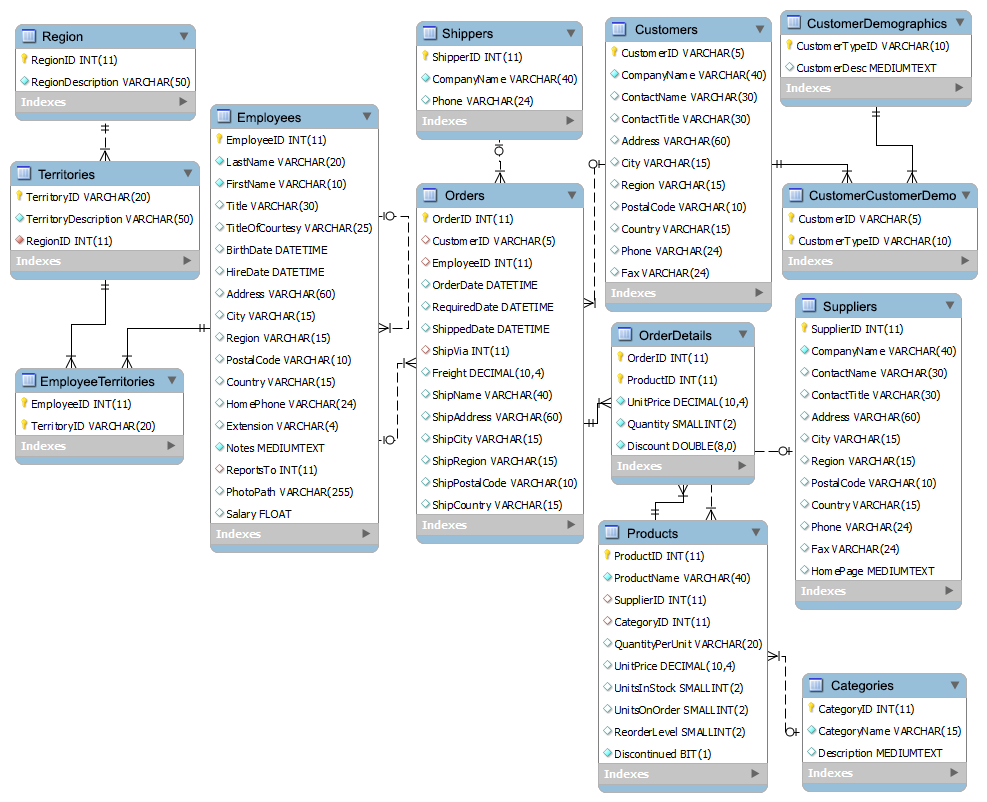

In [1]:
from PIL import Image
image = Image.open('Northwind ERD.png')
image

# **2. PROBLEM STATEMENT**

By the end of this notebook, the author wishes to answer 4 questions, all of which are focusing on deriving data-driven decisions to improve **sales performance** of Northwind. In the attempt to answer these questions, the author determined **products** as the main tool to achieve the objectives. <br> <br>
The questions are listed as the following:
> 1. How was the sales performance trend of the Northwind company? Was it growing or was it declining?
> 1. What products contributed the most to the Northwind's revenue on average? Who supplied them?
> 1. Was there any difference in reorder level between top 25% most sold products and bottom 25% least sold products?
> 1. Who were Northwind's most valuable customers? Was there enough evidence to justify giving them special treatments?

# **3. DATABASE**

## **Connecting to database**

First of all, the database should be able to be accessed via the notebook through SQL queries. To do that, the following codes are executed to connect to `northwind` database. By performing these codes, all contents of the database could be accessed by running normal SQL queries here in the notebook.

In [2]:
# Import modules
import mysql.connector
import numpy as np
import pandas as pd

In [3]:
# Connect to database
mydb = mysql.connector.connect(
                               host = 'localhost',
                               user = 'root',
                               password = '271314',
                               database = 'northwind')

myCursor = mydb.cursor()

In [4]:
# Defining query function
def sql(queries) :
   myCursor.execute(queries)
   myResult = myCursor.fetchall()
   df = pd.DataFrame(myResult, columns=myCursor.column_names)
   return df

## **T1. Comprehensive order details**

This table would be the main table used in this analysis. It consists of 7 tables, namely: `categories`, `customers`, `orderdetails`, `orders`, `products`, `shippers`, and `suppliers`. From these tables, columns that are considered important are aggregated unto the main table. The complete list is provided as follows:
- OrderID from `orders`
- CustomerID from `orders`
- CompanyName AS CustomerCompany from `customers`
- OrderDate from `orders`
- ShippedDate from `orders`
- RequiredDate from `orders`
- DATEDIFF(RequiredDate,ShippedDate) AS DayDifference from `orders` (Generated feature, measured as the difference between required date and shipped date in days)
- ShipCountry from `orders`
- CompanyName AS ShippingCompany from `shippers`
- ProductID from `products`
- ProductName from `products`
- CategoryID from `products`
- Quantity from `orderdetails`
- QuantityPerUnit AS UnitPerQuantity from `products`
- UnitPrice from `products` (Assumed in USD ($) per unit)
- SupplierID from `products`
- CompanyName AS SupplierName from `suppliers`
- Country AS SupplierCountry from `suppliers`

In [5]:
dfComprehensive = sql('''
SELECT
    o.OrderID,
    o.CustomerID,
    cu.CompanyName AS CustomerCompany,
    o.OrderDate,
    o.ShippedDate,
    o.RequiredDate,
    DATEDIFF(o.RequiredDate,o.ShippedDate) AS DayDifference,
    o.ShipCountry,
    s.CompanyName AS ShippingCompany,
    p.ProductID,
    p.ProductName,
    p.CategoryID,
    od.Quantity,
    p.QuantityPerUnit AS UnitPerQuantity,
    p.UnitPrice,
    p.SupplierID,
    su.CompanyName AS SupplierName,
    su.Country AS SupplierCountry
FROM orders o LEFT JOIN customers cu
        USING (CustomerID)
    LEFT JOIN orderdetails od
        USING (OrderID)
    LEFT JOIN products p
        USING (ProductID)
    LEFT JOIN categories c
        USING (CategoryID)
    LEFT JOIN suppliers su
        USING (SupplierID)
    LEFT JOIN shippers s
        ON o.ShipVia = s.ShipperID;
''')
                     
dfComprehensive

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,SupplierID,SupplierName,SupplierCountry
0,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,11,Queso Cabrales,4,12,1 kg pkg.,21.0000,5,Cooperativa de Quesos 'Las Cabras',Spain
1,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,42,Singaporean Hokkien Fried Mee,5,10,32 - 1 kg pkgs.,14.0000,20,Leka Trading,Singapore
2,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,72,Mozzarella di Giovanni,4,5,24 - 200 g pkgs.,34.8000,14,Formaggi Fortini s.r.l.,Italy
3,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,14,Tofu,7,9,40 - 100 g pkgs.,23.2500,6,Mayumi's,Japan
4,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,51,Manjimup Dried Apples,7,40,50 - 300 g pkgs.,53.0000,24,"G'day, Mate",Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,64,Wimmers gute Semmelkndel,5,2,20 bags x 4 pieces,33.2500,12,Plutzer Lebensmittelgromrkte AG,Germany
2151,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,66,Louisiana Hot Spiced Okra,2,1,24 - 8 oz jars,17.0000,2,New Orleans Cajun Delights,USA
2152,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,73,Rd Kaviar,8,2,24 - 150 g jars,15.0000,17,Svensk Sjfda AB,Sweden
2153,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,75,Rhnbru Klosterbier,1,4,24 - 0.5 l bottles,7.7500,12,Plutzer Lebensmittelgromrkte AG,Germany


## **T2. Product categories overview**

This table serves as a general information about the product categories. It is a combination of 2 tables (using common table expression; CTE):
1. Total quantity of products ordered per category
2. Aggregate table for product categories e.g. number of products, total stock, total ongoing restock, total price value, and total discontinued products

using `CategoryId`.

In [6]:
dfCategories = sql('''
WITH cte1 AS
    (
    SELECT 
        p.CategoryID,
        SUM(od.Quantity) AS TotalOrdered
    FROM products p LEFT JOIN categories c 
            USING (CategoryID)
        LEFT JOIN orderdetails od
            USING (ProductID)
    GROUP BY p.CategoryID
    )

SELECT
    c.CategoryID,
    c.CategoryName,
    c.Description,
    COUNT(p.ProductID) AS NumberOfProducts,
    SUM(p.UnitsInStock) AS TotalStock,
    SUM(p.UnitsOnOrder) AS TotalOngoingRestock,
    cte1.TotalOrdered,
    SUM(p.UnitPrice) AS TotalPriceValue,
    SUM(p.Discontinued) AS TotalDiscontinued
FROM products p LEFT JOIN categories c 
        USING (CategoryID)
    LEFT JOIN cte1
        USING (CategoryID)
GROUP BY c.CategoryID
ORDER BY c.CategoryID ASC;
''')

dfCategories

,CategoryID,CategoryName,Description,NumberOfProducts,TotalStock,TotalOngoingRestock,TotalOrdered,TotalPriceValue,TotalDiscontinued
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",12,559,60,9532,455.7500,1
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an...",12,507,170,5298,276.7500,1
2,3,Confections,"Desserts, candies, and sweet breads",13,386,180,7906,327.0800,0
3,4,Dairy Products,Cheeses,10,393,140,9149,287.3000,0
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal",7,308,90,4562,141.7500,1
5,6,Meat/Poultry,Prepared meats,6,165,0,4199,324.0400,4
6,7,Produce,Dried fruit and bean curd,5,100,20,2990,161.8500,1
7,8,Seafood,Seaweed and fish,12,701,120,7681,248.1900,0


## **T3. Product info**

In contrast to the previous table, this table focuses on elaborating the product details for every product ID. The table consists of:
- ProductID from `products`
- ProductName from `products`
- CategoryName from `categories`
- CompanyName AS SupplierName from `suppliers`
- QuantityPerUnit AS UnitPerQuantity from `products`
- UnitPrice from `products` (Assumed in USD ($) per unit)
- UnitsInStock from `products`
- UnitsOnOrder AS OnGoingRestock from `products` 
- ReorderLevel from `products` ('How many times the product has been reordered?')
- Discontinued from `products` (The state of the product, 0 = Available, 1 = Discontinued)

In [7]:
dfProducts = sql('''
SELECT
    p.ProductID,
    p.ProductName,
    c.CategoryName,
    su.CompanyName AS SupplierName,
    p.QuantityPerUnit AS UnitPerQuantity,
    p.UnitPrice,
    p.UnitsInStock,
    p.UnitsOnOrder AS OnGoingRestock,
    p.ReorderLevel,
    p.Discontinued
FROM products p LEFT JOIN categories c 
        USING (CategoryID)
    LEFT JOIN suppliers su
        USING (SupplierID);
''')

dfProducts

,ProductID,ProductName,CategoryName,SupplierName,UnitPerQuantity,UnitPrice,UnitsInStock,OnGoingRestock,ReorderLevel,Discontinued
0,1,Chai,Beverages,Exotic Liquids,10 boxes x 20 bags,18.0000,39,0,10,0
1,2,Chang,Beverages,Exotic Liquids,24 - 12 oz bottles,19.0000,17,40,25,0
2,3,Aniseed Syrup,Condiments,Exotic Liquids,12 - 550 ml bottles,10.0000,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,Condiments,New Orleans Cajun Delights,48 - 6 oz jars,22.0000,53,0,0,0
4,5,Chef Anton's Gumbo Mix,Condiments,New Orleans Cajun Delights,36 boxes,21.3500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,Rd Kaviar,Seafood,Svensk Sjfda AB,24 - 150 g jars,15.0000,101,0,5,0
73,74,Longlife Tofu,Produce,Tokyo Traders,5 kg pkg.,10.0000,4,20,5,0
74,75,Rhnbru Klosterbier,Beverages,Plutzer Lebensmittelgromrkte AG,24 - 0.5 l bottles,7.7500,125,0,25,0
75,76,Lakkalikri,Beverages,Karkki Oy,500 ml,18.0000,57,0,20,0


# **4. DATA MANIPULATION**

Before delving deep into data analysis, it is important to preprocess the data to *clean* it from potential anomalies as well as enrich it new features to compliment the existing records. As stated before, `dfComprehensive` is used as the main data frame to further derive necessary tables for solving the problem statements.<br> <br>
In this section, data manipulation procedures of `dfComprehensive` is discussed thoroughly.

In [8]:
pd.set_option('display.max_columns', None) # Display max columns
import warnings
warnings.simplefilter('ignore')

In [9]:
dfComprehensive

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,SupplierID,SupplierName,SupplierCountry
0,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,11,Queso Cabrales,4,12,1 kg pkg.,21.0000,5,Cooperativa de Quesos 'Las Cabras',Spain
1,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,42,Singaporean Hokkien Fried Mee,5,10,32 - 1 kg pkgs.,14.0000,20,Leka Trading,Singapore
2,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,72,Mozzarella di Giovanni,4,5,24 - 200 g pkgs.,34.8000,14,Formaggi Fortini s.r.l.,Italy
3,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,14,Tofu,7,9,40 - 100 g pkgs.,23.2500,6,Mayumi's,Japan
4,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,51,Manjimup Dried Apples,7,40,50 - 300 g pkgs.,53.0000,24,"G'day, Mate",Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,64,Wimmers gute Semmelkndel,5,2,20 bags x 4 pieces,33.2500,12,Plutzer Lebensmittelgromrkte AG,Germany
2151,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,66,Louisiana Hot Spiced Okra,2,1,24 - 8 oz jars,17.0000,2,New Orleans Cajun Delights,USA
2152,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,73,Rd Kaviar,8,2,24 - 150 g jars,15.0000,17,Svensk Sjfda AB,Sweden
2153,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,75,Rhnbru Klosterbier,1,4,24 - 0.5 l bottles,7.7500,12,Plutzer Lebensmittelgromrkte AG,Germany


## **General info**

In [10]:
# Defining function

def preview(df) :
    dfCheck = []
    for i in df.columns:
        dfCheck.append([
                    i,
                    df[i].dtype,
                    df[i].isna().sum(),
                    round(df[i].isna().sum() / len(df) * 100, 2),
                    df[i].nunique(),
                    df[i].drop_duplicates().values])
    return pd.DataFrame(dfCheck, columns = ['Features', 'DataType', 'Null', 'Proportion', 'Uniques', 'UniqueSample'])

In [11]:
preview(dfComprehensive)

,Features,DataType,Null,Proportion,Uniques,UniqueSample
0,OrderID,int64,0,0.00,830,"[10248, 10249, 10250, 10251, 10252, 10253, 102..."
1,CustomerID,object,0,0.00,89,"[VINET, TOMSP, HANAR, VICTE, SUPRD, CHOPS, RIC..."
2,CustomerCompany,object,0,0.00,89,"[Vins et alcools Chevalier, Toms Spezialitten,..."
3,OrderDate,datetime64[ns],0,0.00,480,"[1996-07-04T00:00:00.000000000, 1996-07-05T00:..."
4,ShippedDate,datetime64[ns],73,3.39,387,"[1996-07-16T00:00:00.000000000, 1996-07-10T00:..."
5,RequiredDate,datetime64[ns],0,0.00,454,"[1996-08-01T00:00:00.000000000, 1996-08-16T00:..."
6,DayDifference,float64,73,3.39,53,"[16.0, 37.0, 24.0, 21.0, 26.0, 8.0, 25.0, 22.0..."
7,ShipCountry,object,0,0.00,21,"[France, Germany, Brazil, Belgium, Switzerland..."
8,ShippingCompany,object,0,0.00,3,"[Federal Shipping, Speedy Express, United Pack..."
9,ProductID,int64,0,0.00,77,"[11, 42, 72, 14, 51, 41, 65, 22, 57, 20, 33, 6..."


## **Data anomalies**

At a glance, `dfComprehensive` is *quite clean* as there are low proportions of missing values and appropriate data types for every features.
However, there are still some anomalies to be cleaned up, namely:

1. Missing values (~3.39%) on both `ShippedDate` and `DayDifference` columns
1. Wrong data type on `UnitPrice` column, it should be `float` instead of `object`

Moving forward, all of the columns will be checked 1 by 1 for any inconsistency in their unique values. Any inconsistencies found are discussed further down  in `Data Cleaning`.

### **Data type conversion**

`UnitPrice` column from `dfComprehensive` is registered as an `object` instead of `float`. The author argues that price should be categorized as `float` since price in essence is not limited to integers, price could be in form of decimals such that the seller can have more freedom in setting up price to meet operational bottomlines.

In [12]:
dfComprehensive['UnitPrice'] = pd.to_numeric(dfComprehensive['UnitPrice'])

dfComprehensive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderID          2155 non-null   int64         
 1   CustomerID       2155 non-null   object        
 2   CustomerCompany  2155 non-null   object        
 3   OrderDate        2155 non-null   datetime64[ns]
 4   ShippedDate      2082 non-null   datetime64[ns]
 5   RequiredDate     2155 non-null   datetime64[ns]
 6   DayDifference    2082 non-null   float64       
 7   ShipCountry      2155 non-null   object        
 8   ShippingCompany  2155 non-null   object        
 9   ProductID        2155 non-null   int64         
 10  ProductName      2155 non-null   object        
 11  CategoryID       2155 non-null   int64         
 12  Quantity         2155 non-null   int64         
 13  UnitPerQuantity  2155 non-null   object        
 14  UnitPrice        2155 non-null   float64

The sum aggregated columns (`TotalStock`, `TotalOngoingRestock`, `TotalOrdered`, `TotalPriceValue`, `TotalDiscontinued`) of `dfCategories` are categorized as an `object`. Here they are converted into their proper data type which is numerics.

In [13]:
l = ['TotalStock', 'TotalOngoingRestock', 'TotalOrdered', 'TotalPriceValue', 'TotalDiscontinued']
for i in l :
    dfCategories[i] = pd.to_numeric(dfCategories[i])

dfCategories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CategoryID           8 non-null      int64  
 1   CategoryName         8 non-null      object 
 2   Description          8 non-null      object 
 3   NumberOfProducts     8 non-null      int64  
 4   TotalStock           8 non-null      float64
 5   TotalOngoingRestock  8 non-null      float64
 6   TotalOrdered         8 non-null      float64
 7   TotalPriceValue      8 non-null      float64
 8   TotalDiscontinued    8 non-null      float64
dtypes: float64(5), int64(2), object(2)
memory usage: 704.0+ bytes


The same argument stated above of converting `UnitPrice` could be used in the case of `dfProducts` since it contains exactly the same column.

In [14]:
dfProducts['UnitPrice'] = pd.to_numeric(dfProducts['UnitPrice'])

dfProducts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductID        77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   CategoryName     77 non-null     object 
 3   SupplierName     77 non-null     object 
 4   UnitPerQuantity  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   OnGoingRestock   77 non-null     int64  
 8   ReorderLevel     77 non-null     int64  
 9   Discontinued     77 non-null     int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 6.1+ KB


### **Missing values**

Recall that `DayDifference` is actually a derived feature of `ShippedDate` and `RequiredDate`. Hence, the missing values of DayDifference actually comes from `ShippedDate`. Before attempting to process the missing values, it is imperative to ask the question: **"Are the missing values actually missing on purpose or caused by human errors such as faulty input?"** <br> <br>
To answer that, let's check the records of missing values.

In [15]:
null = dfComprehensive[dfComprehensive.isna().any(axis = 1) == True]
null

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,SupplierID,SupplierName,SupplierCountry
1963,11008,ERNSH,Ernst Handel,1998-04-08,NaT,1998-05-06,NaN,Austria,Federal Shipping,28,Rssle Sauerkraut,7,70,25 - 825 g cans,45.60,12,Plutzer Lebensmittelgromrkte AG,Germany
1964,11008,ERNSH,Ernst Handel,1998-04-08,NaT,1998-05-06,NaN,Austria,Federal Shipping,34,Sasquatch Ale,1,90,24 - 12 oz bottles,14.00,16,Bigfoot Breweries,USA
1965,11008,ERNSH,Ernst Handel,1998-04-08,NaT,1998-05-06,NaN,Austria,Federal Shipping,71,Flotemysost,4,21,10 - 500 g pkgs.,21.50,15,Norske Meierier,Norway
1991,11019,RANCH,Rancho grande,1998-04-13,NaT,1998-05-11,NaN,Argentina,Federal Shipping,46,Spegesild,8,3,4 - 450 g glasses,12.00,21,Lyngbysild,Denmark
1992,11019,RANCH,Rancho grande,1998-04-13,NaT,1998-05-11,NaN,Argentina,Federal Shipping,49,Maxilaku,3,2,24 - 50 g pkgs.,20.00,23,Karkki Oy,Finland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,64,Wimmers gute Semmelkndel,5,2,20 bags x 4 pieces,33.25,12,Plutzer Lebensmittelgromrkte AG,Germany
2151,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,66,Louisiana Hot Spiced Okra,2,1,24 - 8 oz jars,17.00,2,New Orleans Cajun Delights,USA
2152,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,73,Rd Kaviar,8,2,24 - 150 g jars,15.00,17,Svensk Sjfda AB,Sweden
2153,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,75,Rhnbru Klosterbier,1,4,24 - 0.5 l bottles,7.75,12,Plutzer Lebensmittelgromrkte AG,Germany


**REMARKS**
> - Notice that the missing entries largely occur at the most recent orders (Notice the increasing `OrderID`). This means that the missing values are missing because the orders had not been shipped yet at that time, not because of faulty inputs or human errors
> - For that reason, the author decided **NOT TO REMOVE** the missing values since they are just orders that had not been shipped. Removing this data would reduce the amount of valuable information that could be obtained

### **Duplicated records**

The next will check if there are any duplicated records available in the data frame. What is meant by duplicated records are at least 2 rows that have identical values for all columns. The presence of duplicated records would interfere with data analysis, hence it should be treated accordingly.

In [16]:
dfComprehensive[dfComprehensive.duplicated()]

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,SupplierID,SupplierName,SupplierCountry


**REMARKS**
> No duplicated records are found in `dfComprehensive`.

### **Outliers**

This section focuses on treating outliers. Note that only both numerical and non-index columns would be assessed for outliers.

In [17]:
# Outlier function

def outlier (df, numerical) : 
    q1 = df[numerical].quantile(0.25)
    q2 = df[numerical].quantile(0.5)
    q3 = df[numerical].quantile(0.75)

    iqr = q3 - q1
    o = df[(df[numerical] < (q1 - (1.5 * iqr))) | (df[numerical] > (q3 + (1.5 * iqr)))].index
    return df.loc[o]

In [18]:
# Importing libraries

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'ticks', rc = custom_params)
sns.set_palette(sns.color_palette('deep'))

#### **Day difference outliers**

In [19]:
dfComprehensive[['DayDifference']].describe()

,DayDifference
count,2082.000000
mean,19.466378
std,8.848344
min,-23.000000
25%,18.000000
50%,21.000000
75%,24.000000
max,41.000000


The author is interested to find the outliers of DayDifference. Firstly, recall that DayDifference is a generated feature to measure whether an order is delivered on time or not. It is defined as:

$\begin{align*}
    \text{DayDifference} = \text{ShippedDate} - \text{RequiredDate} \implies
        \begin{cases}
        \text{DayDifference} \geq 0 \Rightarrow \text{Order is delivered before due}\\
        \text{DayDifference} < 0 \Rightarrow \text{Order is delivered late}
        \end{cases}
\end{align*}$

Hence, the point of interest is to find which orders are both outliers and delivered late.

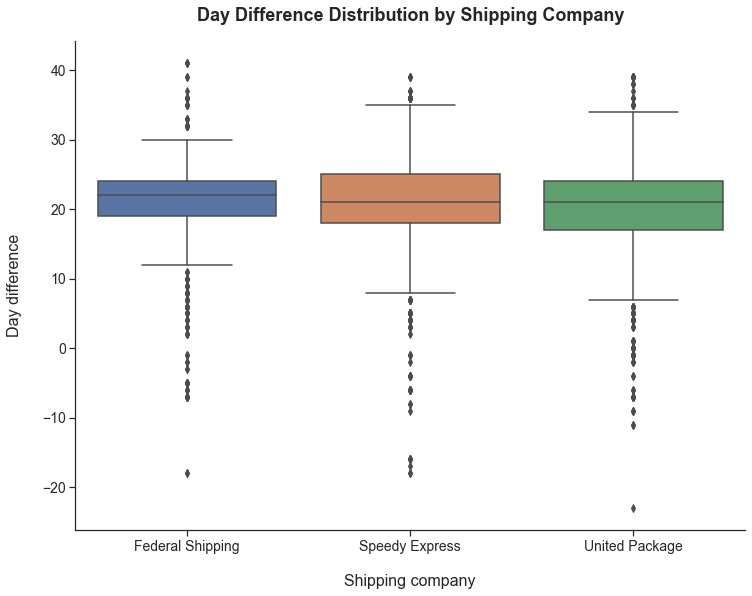

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12, 9))
sns.boxplot(x = dfComprehensive['ShippingCompany'], y = dfComprehensive['DayDifference'])

plt.xlabel('Shipping company', fontsize = 16, labelpad = 20)
plt.ylabel('Day difference', fontsize = 16, labelpad = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.title('Day Difference Distribution by Shipping Company', fontweight = 'bold', fontsize = 18, pad = 20)

plt.show()

As mentioned before, the `DayDifference` outliers are not all bad, because exceedingly fast deliveries are believed to be desirable. Yet, the a large portion of the outliers are actually the late deliveries. Naturally, the first thing to come to mind when assessing timely order deliveries is the shipper company. However, it seems that the late orders are distributed evenly accross all shipper companies.

In [21]:
temp = outlier(dfComprehensive, 'DayDifference')
temp[temp['DayDifference'] < 0]

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,SupplierID,SupplierName,SupplierCountry
47,10264,FOLKO,Folk och f HB,1996-07-24,1996-08-23,1996-08-21,-2.0,Sweden,Federal Shipping,2,Chang,1,35,24 - 12 oz bottles,19.00,1,Exotic Liquids,UK
48,10264,FOLKO,Folk och f HB,1996-07-24,1996-08-23,1996-08-21,-2.0,Sweden,Federal Shipping,41,Jack's New England Clam Chowder,8,25,12 - 12 oz cans,9.65,19,New England Seafood Cannery,USA
61,10271,SPLIR,Split Rail Beer & Ale,1996-08-01,1996-08-30,1996-08-29,-1.0,USA,United Package,33,Geitost,4,24,500 g,2.50,15,Norske Meierier,Norway
83,10280,BERGS,Berglunds snabbkp,1996-08-14,1996-09-12,1996-09-11,-1.0,Sweden,Speedy Express,24,Guaran Fantstica,1,12,12 - 355 ml cans,4.50,10,Refrescos Americanas LTDA,Brazil
84,10280,BERGS,Berglunds snabbkp,1996-08-14,1996-09-12,1996-09-11,-1.0,Sweden,Speedy Express,55,Pt chinois,6,20,24 boxes x 2 pies,24.00,25,Ma Maison,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,10927,LACOR,La corne d'abondance,1998-03-05,1998-04-08,1998-04-02,-6.0,France,Speedy Express,52,Filo Mix,5,5,16 - 2 kg boxes,7.00,24,"G'day, Mate",Australia
1764,10927,LACOR,La corne d'abondance,1998-03-05,1998-04-08,1998-04-02,-6.0,France,Speedy Express,76,Lakkalikri,1,20,500 ml,18.00,23,Karkki Oy,Finland
1844,10960,HILAA,HILARION-Abastos,1998-03-19,1998-04-08,1998-04-02,-6.0,Venezuela,Speedy Express,24,Guaran Fantstica,1,10,12 - 355 ml cans,4.50,10,Refrescos Americanas LTDA,Brazil
1845,10960,HILAA,HILARION-Abastos,1998-03-19,1998-04-08,1998-04-02,-6.0,Venezuela,Speedy Express,41,Jack's New England Clam Chowder,8,24,12 - 12 oz cans,9.65,19,New England Seafood Cannery,USA


**REMARKS**
> - There is seemingly no connection between the day difference outlier distribution and shipping companies
> - The author did try to find the relationship with other categories (not shown in this notebook for conciseness) and found no meaningful connections
> - No outliers are omitted from the data since the their presence would not interfere with the following analyses

#### **Revenue outliers**

One of the main objectives of this analysis is to find valuable insights regarding sales performance. Therefore, finding how the outliers are distributed over every transactions could provide meaningful information, especially if the revenue generated is very large. <br> <br>
In order to do that, a new feature called `Revenue` needs to be generated, which is defined as:

$\begin{align*}
    \text{Revenue} = \text{UnitPrice} \times \text{Quantity}
\end{align*}$

In [22]:
dfComprehensive.insert(loc = 15, column = 'Revenue', value = dfComprehensive['UnitPrice'] * dfComprehensive['Quantity'])

In [23]:
dfComprehensive[['OrderID','UnitPrice','Quantity','Revenue']]

,OrderID,UnitPrice,Quantity,Revenue
0,10248,21.00,12,252.00
1,10248,14.00,10,140.00
2,10248,34.80,5,174.00
3,10249,23.25,9,209.25
4,10249,53.00,40,2120.00
...,...,...,...,...
2150,11077,33.25,2,66.50
2151,11077,17.00,1,17.00
2152,11077,15.00,2,30.00
2153,11077,7.75,4,31.00


In [24]:
dfComprehensive[['Revenue']].describe()

,Revenue
count,2155.000000
mean,672.560237
std,1110.261427
min,6.000000
25%,170.500000
50%,380.000000
75%,760.000000
max,15810.000000


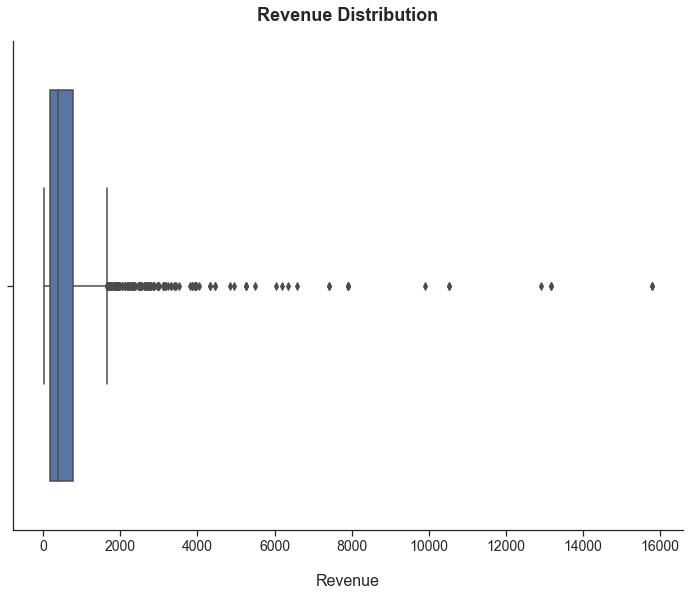

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
sns.boxplot(x = dfComprehensive['Revenue'])

plt.xlabel('Revenue', fontsize = 16, labelpad = 20)
plt.xticks(fontsize = 14)

plt.title('Revenue Distribution', fontweight = 'bold', fontsize = 18, pad = 20)

plt.show()

The author is interested to explore the outliers of at the higher end of the revenue spectrum. To do this, an arbitary threshold at **98% quantile ($3295.2)** is chosen to represent the most extreme revenue contributors of Northwind.

In [26]:
temp = outlier(dfComprehensive, 'Revenue')
temp[temp['Revenue'] > dfComprehensive['Revenue'].quantile(0.98)].sort_values('Revenue', ascending = True)

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,Revenue,SupplierID,SupplierName,SupplierCountry
641,10490,HILAA,HILARION-Abastos,1997-03-31,1997-04-03,1997-04-28,25.0,Venezuela,United Package,59,Raclette Courdavault,4,60,5 kg pkg.,55.00,3300.00,28,Gai pturage,France
615,10479,RATTC,Rattlesnake Canyon Grocery,1997-03-19,1997-03-21,1997-04-16,26.0,USA,Federal Shipping,59,Raclette Courdavault,4,60,5 kg pkg.,55.00,3300.00,28,Gai pturage,France
1695,10895,ERNSH,Ernst Handel,1998-02-18,1998-02-23,1998-03-18,23.0,Austria,Speedy Express,60,Camembert Pierrot,4,100,15 - 300 g rounds,34.00,3400.00,28,Gai pturage,France
920,10595,ERNSH,Ernst Handel,1997-07-10,1997-07-14,1997-08-07,24.0,Austria,Speedy Express,61,Sirop d'rable,2,120,24 - 500 ml bottles,28.50,3420.00,29,Forts d'rables,Canada
183,10316,RATTC,Rattlesnake Canyon Grocery,1996-09-27,1996-10-08,1996-10-25,17.0,USA,Federal Shipping,62,Tarte au sucre,3,70,48 pies,49.30,3451.00,29,Forts d'rables,Canada
200,10324,SAVEA,Save-a-lot Markets,1996-10-08,1996-10-10,1996-11-05,26.0,USA,Speedy Express,63,Vegie-spread,2,80,15 - 625 g jars,43.90,3512.00,7,"Pavlova, Ltd.",Australia
1129,10678,SAVEA,Save-a-lot Markets,1997-09-23,1997-10-16,1997-10-21,5.0,USA,Federal Shipping,12,Queso Manchego La Pastora,4,100,10 - 500 g pkgs.,38.00,3800.00,5,Cooperativa de Quesos 'Las Cabras',Spain
53,10267,FRANK,Frankenversand,1996-07-29,1996-08-06,1996-08-26,20.0,Germany,Speedy Express,59,Raclette Courdavault,4,70,5 kg pkg.,55.00,3850.00,28,Gai pturage,France
484,10430,ERNSH,Ernst Handel,1997-01-30,1997-02-03,1997-02-13,10.0,Austria,Speedy Express,59,Raclette Courdavault,4,70,5 kg pkg.,55.00,3850.00,28,Gai pturage,France
948,10607,SAVEA,Save-a-lot Markets,1997-07-22,1997-07-25,1997-08-19,25.0,USA,Speedy Express,17,Alice Mutton,6,100,20 - 1 kg tins,39.00,3900.00,7,"Pavlova, Ltd.",Australia


**REMARKS**
> - A small outlier fraction of orders contribute a significant amount to company's revenue
> - No outliers are omitted from the data since the author deems these outliers could be analyzed to provide more meaningful business insight
> - A deeper analysis regarding which products are most valuable to Northwind in terms of revenue are discussed in Section 5 Q2

## **Data cleaning**

### **Data inconsistencies**

Every unique values of the column are checked. For convenience, the columns are checked in batch according to their data types. <br> <br>

To view the full output, it is suggested to open the data in a **text editor** due to the sheer amount data.

#### **object (Categorical)**

In [27]:
for i in dfComprehensive.columns[dfComprehensive.dtypes == 'object'] :
    print(i, '\n')
    print(dfComprehensive[i].unique().tolist(), '\n')

CustomerID 

['VINET', 'TOMSP', 'HANAR', 'VICTE', 'SUPRD', 'CHOPS', 'RICSU', 'WELLI', 'HILAA', 'ERNSH', 'CENTC', 'OTTIK', 'QUEDE', 'RATTC', 'FOLKO', 'BLONP', 'WARTH', 'FRANK', 'GROSR', 'WHITC', 'SPLIR', 'QUICK', 'MAGAA', 'TORTU', 'MORGK', 'BERGS', 'LEHMS', 'ROMEY', 'LILAS', 'RICAR', 'REGGC', 'BSBEV', 'COMMI', 'TRADH', 'HUNGO', 'WANDK', 'GODOS', 'OLDWO', 'LONEP', 'ANATR', 'THEBI', 'DUMON', 'ISLAT', 'PERIC', 'KOENE', 'SAVEA', 'BOLID', 'FURIB', 'BONAP', 'MEREP', 'PRINI', 'SIMOB', 'FAMIA', 'LAMAI', 'PICCO', 'AROUT', 'SEVES', 'DRACD', 'EASTC', 'ANTON', 'GALED', 'VAFFE', 'QUEEN', 'WOLZA', 'HUNGC', 'SANTG', 'BOTTM', 'LINOD', 'FOLIG', 'OCEAN', 'FRANS', 'GOURL', 'CONSH', 'RANCH', 'LAZYK', 'LAUGB', 'BLAUS', 'NORTS', 'CACTU', 'GREAL', 'MAISD', 'TRAIH', 'LETSS', 'WILMK', 'THECR', 'ALFKI', 'FRANR', 'SPECD', 'LACOR'] 

CustomerCompany 

['Vins et alcools Chevalier', 'Toms Spezialitten', 'Hanari Carnes', 'Victuailles en stock', 'Suprmes dlices', 'Chop-suey Chinese', 'Richter Supermarkt', 'Wellington 

**REMARKS**
> No inconsistencies are found, including typos, and ambiguous characters {?, 99999, NA, /, etc.}, and empty spaces.

#### **datetime64**

In [28]:
for i in dfComprehensive.columns[dfComprehensive.dtypes == 'datetime64[ns]'] :
    print(i, '\n')
    print(dfComprehensive[i].unique(), '\n')

OrderDate 

['1996-07-04T00:00:00.000000000' '1996-07-05T00:00:00.000000000'
 '1996-07-08T00:00:00.000000000' '1996-07-09T00:00:00.000000000'
 '1996-07-10T00:00:00.000000000' '1996-07-11T00:00:00.000000000'
 '1996-07-12T00:00:00.000000000' '1996-07-15T00:00:00.000000000'
 '1996-07-16T00:00:00.000000000' '1996-07-17T00:00:00.000000000'
 '1996-07-18T00:00:00.000000000' '1996-07-19T00:00:00.000000000'
 '1996-07-22T00:00:00.000000000' '1996-07-23T00:00:00.000000000'
 '1996-07-24T00:00:00.000000000' '1996-07-25T00:00:00.000000000'
 '1996-07-26T00:00:00.000000000' '1996-07-29T00:00:00.000000000'
 '1996-07-30T00:00:00.000000000' '1996-07-31T00:00:00.000000000'
 '1996-08-01T00:00:00.000000000' '1996-08-02T00:00:00.000000000'
 '1996-08-05T00:00:00.000000000' '1996-08-06T00:00:00.000000000'
 '1996-08-07T00:00:00.000000000' '1996-08-08T00:00:00.000000000'
 '1996-08-09T00:00:00.000000000' '1996-08-12T00:00:00.000000000'
 '1996-08-13T00:00:00.000000000' '1996-08-14T00:00:00.000000000'
 '1996-08-15T

**REMARKS**
> No inconsistencies are found, including typos, and ambiguous characters {?, 99999, NA, /, etc.}, and empty spaces.

#### **int64 (Numerical)**

In [29]:
for i in dfComprehensive.columns[dfComprehensive.dtypes == 'int64'] :
    print(i, '\n')
    print(dfComprehensive[i].unique().tolist(), '\n')

OrderID 

[10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10

**REMARKS**
> No inconsistencies are found, including typos, and ambiguous characters {?, 99999, NA, /, etc.}, and empty spaces.

#### **float64 (Numerical)**

In [30]:
for i in dfComprehensive.columns[dfComprehensive.dtypes == 'float64'] :
    print(i, '\n')
    print(dfComprehensive[i].unique().tolist(), '\n')

DayDifference 

[16.0, 37.0, 24.0, 21.0, 26.0, 8.0, 25.0, 22.0, 18.0, 17.0, 20.0, -2.0, 10.0, 5.0, 27.0, -1.0, 7.0, 19.0, 23.0, 15.0, 36.0, 2.0, -6.0, 9.0, 34.0, 38.0, 39.0, 6.0, 4.0, -7.0, 13.0, 12.0, -18.0, 33.0, 35.0, -4.0, 11.0, 1.0, -16.0, 3.0, 32.0, 28.0, -3.0, 14.0, 30.0, -9.0, -23.0, 0.0, -11.0, -8.0, 41.0, -5.0, -17.0, nan] 

UnitPrice 

[21.0, 14.0, 34.8, 23.25, 53.0, 9.65, 21.05, 19.5, 81.0, 2.5, 34.0, 12.5, 18.0, 20.0, 4.5, 24.0, 10.0, 19.0, 17.45, 55.0, 32.8, 13.0, 43.9, 21.35, 32.0, 26.0, 49.3, 15.0, 30.0, 38.0, 25.89, 39.0, 18.4, 123.79, 46.0, 31.0, 21.5, 6.0, 45.6, 19.45, 7.75, 9.2, 15.5, 12.0, 7.45, 33.25, 62.5, 36.0, 17.0, 22.0, 25.0, 13.25, 7.0, 263.5, 31.23, 9.5, 9.0, 40.0, 16.25, 12.75, 28.5, 97.0] 

Revenue 

[252.0, 140.0, 174.0, 209.25, 2120.0, 96.5, 1855.0, 315.75, 126.0, 292.5, 421.0, 3240.0, 62.5, 1360.0, 250.0, 756.0, 800.0, 67.5, 504.0, 210.0, 380.0, 610.75, 475.0, 1650.0, 491.99999999999994, 156.0, 1097.5, 108.0, 195.0, 950.0, 1387.75, 192.0, 100.0, 26.0, 

**REMARKS**
> No inconsistencies are found, including typos, and ambiguous characters {?, 99999, NA, /, etc.}, and empty spaces.

### **Cleaned data preview**

In [31]:
preview(dfComprehensive)

,Features,DataType,Null,Proportion,Uniques,UniqueSample
0,OrderID,int64,0,0.00,830,"[10248, 10249, 10250, 10251, 10252, 10253, 102..."
1,CustomerID,object,0,0.00,89,"[VINET, TOMSP, HANAR, VICTE, SUPRD, CHOPS, RIC..."
2,CustomerCompany,object,0,0.00,89,"[Vins et alcools Chevalier, Toms Spezialitten,..."
3,OrderDate,datetime64[ns],0,0.00,480,"[1996-07-04T00:00:00.000000000, 1996-07-05T00:..."
4,ShippedDate,datetime64[ns],73,3.39,387,"[1996-07-16T00:00:00.000000000, 1996-07-10T00:..."
5,RequiredDate,datetime64[ns],0,0.00,454,"[1996-08-01T00:00:00.000000000, 1996-08-16T00:..."
6,DayDifference,float64,73,3.39,53,"[16.0, 37.0, 24.0, 21.0, 26.0, 8.0, 25.0, 22.0..."
7,ShipCountry,object,0,0.00,21,"[France, Germany, Brazil, Belgium, Switzerland..."
8,ShippingCompany,object,0,0.00,3,"[Federal Shipping, Speedy Express, United Pack..."
9,ProductID,int64,0,0.00,77,"[11, 42, 72, 14, 51, 41, 65, 22, 57, 20, 33, 6..."


In [32]:
preview(dfCategories)

,Features,DataType,Null,Proportion,Uniques,UniqueSample
0,CategoryID,int64,0,0.0,8,"[1, 2, 3, 4, 5, 6, 7, 8]"
1,CategoryName,object,0,0.0,8,"[Beverages, Condiments, Confections, Dairy Pro..."
2,Description,object,0,0.0,8,"[Soft drinks, coffees, teas, beers, and ales, ..."
3,NumberOfProducts,int64,0,0.0,6,"[12, 13, 10, 7, 6, 5]"
4,TotalStock,float64,0,0.0,8,"[559.0, 507.0, 386.0, 393.0, 308.0, 165.0, 100..."
5,TotalOngoingRestock,float64,0,0.0,8,"[60.0, 170.0, 180.0, 140.0, 90.0, 0.0, 20.0, 1..."
6,TotalOrdered,float64,0,0.0,8,"[9532.0, 5298.0, 7906.0, 9149.0, 4562.0, 4199...."
7,TotalPriceValue,float64,0,0.0,8,"[455.75, 276.75, 327.08, 287.3, 141.75, 324.04..."
8,TotalDiscontinued,float64,0,0.0,3,"[1.0, 0.0, 4.0]"


In [33]:
preview(dfProducts)

,Features,DataType,Null,Proportion,Uniques,UniqueSample
0,ProductID,int64,0,0.0,77,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,ProductName,object,0,0.0,77,"[Chai, Chang, Aniseed Syrup, Chef Anton's Caju..."
2,CategoryName,object,0,0.0,8,"[Beverages, Condiments, Produce, Meat/Poultry,..."
3,SupplierName,object,0,0.0,29,"[Exotic Liquids, New Orleans Cajun Delights, G..."
4,UnitPerQuantity,object,0,0.0,70,"[10 boxes x 20 bags, 24 - 12 oz bottles, 12 - ..."
5,UnitPrice,float64,0,0.0,62,"[18.0, 19.0, 10.0, 22.0, 21.35, 25.0, 30.0, 40..."
6,UnitsInStock,int64,0,0.0,51,"[39, 17, 13, 53, 0, 120, 15, 6, 29, 31, 22, 86..."
7,OnGoingRestock,int64,0,0.0,10,"[0, 40, 70, 30, 50, 10, 60, 80, 100, 20]"
8,ReorderLevel,int64,0,0.0,7,"[10, 25, 0, 30, 5, 15, 20]"
9,Discontinued,int64,0,0.0,2,"[0, 1]"


## **Data frame processing**

### **Total revenue and number of orders (Monthly)**

This table is used to answer Q1. It is basically an aggregated column of `Revenue` and `OrderID` in a monthly timeframe to measure the performance of Northwind's sales over time.

In [34]:
q1 = dfComprehensive[['OrderDate','Revenue','OrderID']]
q1['MonthlyOrderDate'] = q1['OrderDate'].dt.to_period('M')
q1 = q1.groupby('MonthlyOrderDate')[['Revenue', 'OrderID']].agg(['sum','count'])
q1.rename({'sum' : 'TotalRevenue', 'count' : 'NumberOfOrders'}, axis = 1, inplace = True)
q1 = q1.xs([('Revenue', 'TotalRevenue'), ('OrderID', 'NumberOfOrders')], axis = 1)
q1

,Revenue,OrderID
,TotalRevenue,NumberOfOrders
MonthlyOrderDate,,
1996-07,37779.85,59
1996-08,33285.49,69
1996-09,34565.60,57
1996-10,51528.69,73
1996-11,62163.99,66
1996-12,63721.23,81
1997-01,83400.47,85
1997-02,51561.06,79


### **Largest contributors of sales by product categories & products**

These tables are constructed to answer Q2. First, the author want to find the largest contributor categories of sales.

In [71]:
categoriesContributor = dfComprehensive.groupby('CategoryID')[['OrderID', 'Quantity', 'Revenue']].agg(
                                                                                        {
                                                                                         'OrderID' : [('NumberOfOrders', 'count')],
                                                                                         'Quantity' : [('TotalQuantity', 'sum')],
                                                                                         'Revenue' : [('TotalRevenue', 'sum')]
                                                                                        }
                                                                                   )
categoriesContributor.columns = categoriesContributor.columns.droplevel() # Remove column nesting
categoriesContributor

,NumberOfOrders,TotalQuantity,TotalRevenue
CategoryID,,,
1,404,9532,309582.25
2,216,5298,122343.00
3,334,7906,190328.54
4,366,9149,269128.30
5,196,4562,106848.00
6,173,4199,190682.69
7,136,2990,111395.00
8,330,7681,149059.53


The table above could be manipulated further to construct a richer table that contains category name, number of products, and the total revenue for each respective categories as shown below.

In [36]:
temp = categoriesContributor
temp = temp[['TotalRevenue']].sort_values('TotalRevenue', ascending = False)
temp['Proportion'] = round(temp['TotalRevenue'] / np.sum(temp['TotalRevenue']) * 100, 2)
temp = pd.merge(temp, dfCategories[['CategoryID', 'CategoryName', 'NumberOfProducts']], on = ['CategoryID'], how = 'left')

In [37]:
temp = temp[['CategoryID', 'CategoryName', 'NumberOfProducts', 'TotalRevenue', 'Proportion']]
q2a = temp
q2a['CumulativeSum'] = q2a['Proportion'].cumsum()
q2a

,CategoryID,CategoryName,NumberOfProducts,TotalRevenue,Proportion,CumulativeSum
0,1,Beverages,12,309582.25,21.36,21.36
1,4,Dairy Products,10,269128.30,18.57,39.93
2,6,Meat/Poultry,6,190682.69,13.16,53.09
3,3,Confections,13,190328.54,13.13,66.22
4,8,Seafood,12,149059.53,10.28,76.50
5,2,Condiments,12,122343.00,8.44,84.94
6,7,Produce,5,111395.00,7.69,92.63
7,5,Grains/Cereals,7,106848.00,7.37,100.00


Then, the largest contributor products of sales are also constructed with the same manner.

In [38]:
productsContributor = dfComprehensive.groupby('ProductName')[['OrderID', 'Quantity', 'Revenue']].agg(
                                                                                        {
                                                                                         'OrderID' : [('NumberOfOrders', 'count')],
                                                                                         'Quantity' : [('TotalQuantity', 'sum')],
                                                                                         'Revenue' : [('TotalRevenue', 'sum')]
                                                                                        }
                                                                                   )
productsContributor.columns = productsContributor.columns.droplevel() # Remove column nesting
productsContributor

,NumberOfOrders,TotalQuantity,TotalRevenue
ProductName,,,
Alice Mutton,37,978,38142.00
Aniseed Syrup,12,328,3280.00
Boston Crab Meat,41,1103,20295.20
Camembert Pierrot,51,1577,53618.00
Carnarvon Tigers,27,539,33687.50
...,...,...,...
Uncle Bob's Organic Dried Pears,29,763,22890.00
Valkoinen suklaa,10,235,3818.75
Vegie-spread,17,445,19535.50


In [39]:
temp2 = productsContributor
temp2 = temp2[['TotalRevenue']].sort_values('TotalRevenue', ascending = False)
temp2['Proportion'] = round(temp2['TotalRevenue'] / np.sum(temp2['TotalRevenue']) * 100, 2)
temp2 = pd.merge(temp2, dfProducts[['ProductName', 'CategoryName', 'SupplierName']], on = ['ProductName'], how = 'left')

The threshold value of `15` was chosen since about 50% of total revenue generated comes from the top-15 best performing products (out of 77).

In [40]:
temp2 = temp2[['ProductName', 'CategoryName', 'SupplierName', 'TotalRevenue', 'Proportion']]
temp2['CumulativeSum'] = temp2['Proportion'].cumsum()
temp2.head(15)

# Create others row as an aggregation for the index > 15
q2b = temp2[:15].copy()
q2b.loc[len(q2b.index)] = ['Others', 'Others', 'Others', temp2['TotalRevenue'][15:].sum(), temp2['Proportion'][15:].sum(), 100]
q2b

,ProductName,CategoryName,SupplierName,TotalRevenue,Proportion,CumulativeSum
0,Cte de Blaye,Beverages,Aux joyeux ecclsiastiques,164160.50,11.33,11.33
1,Thringer Rostbratwurst,Meat/Poultry,Plutzer Lebensmittelgromrkte AG,92347.34,6.37,17.70
2,Raclette Courdavault,Dairy Products,Gai pturage,82280.00,5.68,23.38
3,Camembert Pierrot,Dairy Products,Gai pturage,53618.00,3.70,27.08
4,Tarte au sucre,Confections,Forts d'rables,53391.90,3.68,30.76
5,Gnocchi di nonna Alice,Grains/Cereals,Pasta Buttini s.r.l.,47994.00,3.31,34.07
6,Manjimup Dried Apples,Produce,"G'day, Mate",46958.00,3.24,37.31
7,Alice Mutton,Meat/Poultry,"Pavlova, Ltd.",38142.00,2.63,39.94
8,Carnarvon Tigers,Seafood,"Pavlova, Ltd.",33687.50,2.32,42.26
9,Rssle Sauerkraut,Produce,Plutzer Lebensmittelgromrkte AG,29184.00,2.01,44.27


The author also creates a pivot table of total quantity sold in an uptrend period (discussed in Section 5) based on categories. This table would be used to construct a timeseries chart.

In [72]:
q2c = dfComprehensive
q2c['MonthlyOrderDate'] = q2c['OrderDate'].dt.to_period('M')
q2c = q2c[(q2c['MonthlyOrderDate'] >= '1997-11') & (q2c['MonthlyOrderDate'] <= '1998-04')]
q2c = pd.pivot_table(q2c, values = 'Quantity', index = 'CategoryID', columns = 'MonthlyOrderDate', aggfunc = np.sum)
q2c

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,Revenue,SupplierID,SupplierName,SupplierCountry,MonthlyOrderDate
0,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,11,Queso Cabrales,4,12,1 kg pkg.,21.00,252.00,5,Cooperativa de Quesos 'Las Cabras',Spain,1996-07
1,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,42,Singaporean Hokkien Fried Mee,5,10,32 - 1 kg pkgs.,14.00,140.00,20,Leka Trading,Singapore,1996-07
2,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,72,Mozzarella di Giovanni,4,5,24 - 200 g pkgs.,34.80,174.00,14,Formaggi Fortini s.r.l.,Italy,1996-07
3,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,14,Tofu,7,9,40 - 100 g pkgs.,23.25,209.25,6,Mayumi's,Japan,1996-07
4,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,51,Manjimup Dried Apples,7,40,50 - 300 g pkgs.,53.00,2120.00,24,"G'day, Mate",Australia,1996-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,64,Wimmers gute Semmelkndel,5,2,20 bags x 4 pieces,33.25,66.50,12,Plutzer Lebensmittelgromrkte AG,Germany,1998-05
2151,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,66,Louisiana Hot Spiced Okra,2,1,24 - 8 oz jars,17.00,17.00,2,New Orleans Cajun Delights,USA,1998-05
2152,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,73,Rd Kaviar,8,2,24 - 150 g jars,15.00,30.00,17,Svensk Sjfda AB,Sweden,1998-05
2153,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,75,Rhnbru Klosterbier,1,4,24 - 0.5 l bottles,7.75,31.00,12,Plutzer Lebensmittelgromrkte AG,Germany,1998-05


### **Supplier contribution to total revenue**

In addition to the tables above, below is the summary of supplier contribution to the total revenue (to complement Q2).

In [78]:
temp = productsContributor
temp = temp[['TotalRevenue']].sort_values('TotalRevenue', ascending = False)
temp['Proportion'] = round(temp['TotalRevenue'] / np.sum(temp['TotalRevenue']) * 100, 2)
temp = pd.merge(temp, dfProducts[['ProductName', 'CategoryName', 'SupplierName']], on = ['ProductName'], how = 'left')
temp = temp.groupby('SupplierName')[['TotalRevenue', 'Proportion']].sum().sort_values('TotalRevenue', ascending = False)
q2d = temp
q2d
temp

,ProductName,TotalRevenue,Proportion,CategoryName,SupplierName
0,Cte de Blaye,164160.50,11.33,Beverages,Aux joyeux ecclsiastiques
1,Thringer Rostbratwurst,92347.34,6.37,Meat/Poultry,Plutzer Lebensmittelgromrkte AG
2,Raclette Courdavault,82280.00,5.68,Dairy Products,Gai pturage
3,Camembert Pierrot,53618.00,3.70,Dairy Products,Gai pturage
4,Tarte au sucre,53391.90,3.68,Confections,Forts d'rables
...,...,...,...,...,...
72,Longlife Tofu,2970.00,0.20,Produce,Tokyo Traders
73,Laughing Lumberjack Lager,2576.00,0.18,Beverages,Bigfoot Breweries
74,Genen Shouyu,1891.00,0.13,Condiments,Mayumi's
75,Geitost,1887.50,0.13,Dairy Products,Norske Meierier


### **Top & bottom 25% products by quantity ordered**

These tables are constructed to answer Q3. Basically, these tables contain the top & bottom 25% of products by quantity ordered. Here `LIMIT = 19 `is set as the 25% of the total products (77). It is equivalent as the quantile of 25% and 75%.

In [43]:
q3a = sql('''
SELECT 
	p.ProductID,
    p.ProductName,
	p.ReorderLevel,
    SUM(od.Quantity) AS TotalQuantityOrdered
FROM products p LEFT JOIN orderdetails od
		USING (ProductID)
	LEFT JOIN orders o
		USING (OrderID)
GROUP BY p.ProductID
ORDER BY SUM(od.Quantity) DESC
LIMIT 19;
''')

q3a['TotalQuantityOrdered'] = pd.to_numeric(q3a['TotalQuantityOrdered'])
q3a['Group'] = 'Top 25%'
q3a

,ProductID,ProductName,ReorderLevel,TotalQuantityOrdered,Group
0,60,Camembert Pierrot,0,1577.0,Top 25%
1,59,Raclette Courdavault,0,1496.0,Top 25%
2,31,Gorgonzola Telino,20,1397.0,Top 25%
3,56,Gnocchi di nonna Alice,30,1263.0,Top 25%
4,16,Pavlova,10,1158.0,Top 25%
5,75,Rhnbru Klosterbier,25,1155.0,Top 25%
6,24,Guaran Fantstica,0,1125.0,Top 25%
7,40,Boston Crab Meat,30,1103.0,Top 25%
8,62,Tarte au sucre,0,1083.0,Top 25%
9,2,Chang,25,1057.0,Top 25%


In [44]:
q3b = sql('''
SELECT 
	p.ProductID,
    p.ProductName,
	p.ReorderLevel,
    SUM(od.Quantity) AS TotalQuantityOrdered
FROM products p LEFT JOIN orderdetails od
		USING (ProductID)
	LEFT JOIN orders o
		USING (OrderID)
GROUP BY p.ProductID
ORDER BY SUM(od.Quantity) ASC
LIMIT 19;
''')

q3b['TotalQuantityOrdered'] = pd.to_numeric(q3b['TotalQuantityOrdered'])
q3b['Group'] = 'Bottom 25%'
q3b

,ProductID,ProductName,ReorderLevel,TotalQuantityOrdered,Group
0,9,Mishi Kobe Niku,0,95.0,Bottom 25%
1,15,Genen Shouyu,5,122.0,Bottom 25%
2,37,Gravad lax,25,125.0,Bottom 25%
3,48,Chocolade,25,138.0,Bottom 25%
4,67,Laughing Lumberjack Lager,10,184.0,Bottom 25%
5,50,Valkoinen suklaa,30,235.0,Bottom 25%
6,66,Louisiana Hot Spiced Okra,20,239.0,Bottom 25%
7,73,Rd Kaviar,5,293.0,Bottom 25%
8,32,Mascarpone Fabioli,25,297.0,Bottom 25%
9,74,Longlife Tofu,5,297.0,Bottom 25%


### Northwind's customer lifetime value and total revenue by country

These tables are constructed to answer Q4. The first table lists down the total revenue generated by country, along with the number of orders and total quantity ordered.

In [45]:
q4a = dfComprehensive.groupby('ShipCountry')[['OrderID', 'Quantity', 'Revenue']].agg(
                                                                                {
                                                                                    'OrderID' : [('NumberOfOrders', 'count')],
                                                                                    'Quantity' : [('TotalQuantity', 'sum')],
                                                                                    'Revenue' : [('TotalRevenue', 'sum')]
                                                                                }
                                                                            )
q4a.columns = q4a.columns.droplevel() # Remove column nesting

In [46]:

q4a = q4a.sort_values('TotalRevenue', ascending = False)
q4a['Proportion'] = round(q4a['TotalRevenue'] / np.sum(q4a['TotalRevenue']) * 100, 2)
q4a

,NumberOfOrders,TotalQuantity,TotalRevenue,Proportion
ShipCountry,,,,
USA,352,9330,280738.38,19.37
Germany,328,9213,257630.67,17.78
Austria,125,5167,149985.09,10.35
Brazil,203,4247,123734.73,8.54
France,184,3254,93609.16,6.46
Venezuela,118,2936,65647.19,4.53
UK,135,2742,64865.15,4.48
Canada,75,1984,61900.15,4.27
Sweden,97,2235,61833.70,4.27


The second table lists down the top 18 customers with the highest lifetime value. Here the number `18` is chosen arbitrarily to contain over 60% of Northwind's gross revenue. To put it to scale, there are 89 total customers, therefore roughly this 20% proportion of customers accounts for more than half of Northwind's total revenue.

In [47]:
q4b = dfComprehensive.groupby(['CustomerID', 'CustomerCompany', 'ShipCountry'])[['Revenue']].sum()
q4b.reset_index(inplace = True)
q4b.rename({'ShipCountry' : 'Country', 'Revenue' : 'LifetimeValue'}, axis = 1, inplace = True)
q4b['Proportion'] = round(q4b['LifetimeValue'] / np.sum(q4b['LifetimeValue']) * 100, 2)
q4b = q4b.sort_values('LifetimeValue', ascending = False)
q4b['CumulativeSum'] = q4b['Proportion'].cumsum()
q4b.reset_index(drop = True).head(18)

,CustomerID,CustomerCompany,Country,LifetimeValue,Proportion,CumulativeSum
0,QUICK,QUICK-Stop,Germany,122199.74,8.43,8.43
1,SAVEA,Save-a-lot Markets,USA,120718.85,8.33,16.76
2,ERNSH,Ernst Handel,Austria,120390.09,8.31,25.07
3,HUNGO,Hungry Owl All-Night Grocers,Ireland,60397.91,4.17,29.24
4,RATTC,Rattlesnake Canyon Grocery,USA,58562.42,4.04,33.28
5,MEREP,Mre Paillarde,Canada,36878.50,2.54,35.82
6,HANAR,Hanari Carnes,Brazil,34916.60,2.41,38.23
7,QUEEN,Queen Cozinha,Brazil,34043.90,2.35,40.58
8,FOLKO,Folk och f HB,Sweden,33477.95,2.31,42.89
9,KOENE,Kniglich Essen,Germany,32902.62,2.27,45.16


# **5. DATA VISUALIZATION & STATISTICS**

## **Q1. How was the sales performance trend of the Northwind company? Was it growing or was it declining?**

In [48]:
import plotly.express as px
import plotly.graph_objects as go
import plotly as py
py.offline.init_notebook_mode(connected=True)

Here, total revenue and number of orders are chosen as a metric to measure the sales performance of Northwind.
 - The total revenue is chosen as a proxy to profits (since the database does not provide the buy price, profits couldn't be calculated), with the assumption of larger revenue would yield in a larger profits
 - Number of orders is chosen as a secondary metric of sales performance since more orders are the primary driver of sales performance

In [49]:
fig = py.subplots.make_subplots(rows = 2, cols = 1)

fig.append_trace(go.Scatter(
                            name = 'Total revenue',
                            x = q1.index.to_timestamp(),
                            y = q1[('Revenue', 'TotalRevenue')]
                           ),
                            row = 1,
                            col = 1)

fig.append_trace(go.Scatter(
                            name = 'Number of orders',
                            x = q1.index.to_timestamp(),
                            y = q1[('OrderID', 'NumberOfOrders')]
                           ),
                            row = 2,
                            col = 1)

# Add scroll scaling functionality
config = dict({'scrollZoom' : True})

fig.update_layout(title_text = "Northwind's Performance Over Time",
                  plot_bgcolor ='#FFF',  # Sets background color to white
                  xaxis = dict(
                               linecolor = '#BCCCDC',  # Sets color of x-axis line
                               showgrid = False  # Removes X-axis grid lines
                              ),
                  yaxis = dict(
                               linecolor = '#BCCCDC',  # Sets color of y-axis line
                               showgrid = False,  # Removes Y-axis grid lines    
                              ),
                  xaxis2 = dict(
                                linecolor = '#BCCCDC',  # Sets color of x-axis line
                                showgrid = False  # Removes X-axis grid lines
                               ),
                  yaxis2 = dict(
                                linecolor = '#BCCCDC',  # Sets color of y-axis line
                                showgrid = False,  # Removes Y-axis grid lines    
                               ),
                  height = 700
                 )

# Format x-axis
fig.update_xaxes(
                 dtick = 'M1',
                 tickformat = '%b\n%Y')

# Format y-axis
fig.update_yaxes(title_text = 'Total revenue ($)', row = 1, col = 1)
fig.update_yaxes(title_text = 'Number of orders', row = 2, col = 1)

fig.add_vline(x = '1998-04', line_width = 2, line_dash = 'dash', line_color = '#BCCCDC')

fig.show(config = config)

**REMARKS**
> - The shape of both total revenue and number of orders are similar. This suggests that these metrics are both related to each other and can be used as a metric of sales performance. In general, total revenue increases with increasing number of orders
> - In periods where number of orders diverge with total revenue, it indicates a purchase of high value products (high price, low quantity volume)
> - Northwind's performance showed signs of strength over the period of Jul 1996 to Jan 1997
> - From Jan 1997 to Nov 1997, Northwind suffers a period of stagnation where the total revenue was just ranging between 39K to 70K USD
> - From Nov 1997 to Apr 1998, Northwind sales saw an uptrend, peaking at 134.6K USD of revenue. From this data, we could theoretically infer that whatever strategy was implemented during this period to be successful in driving the sales. However, we do not have such access to the data
> - The seemingly downtrend period after the peak in Apr 1998 to May 1998 should be disregarded since it is caused by incomplete data. There were only 6 days reported (out of 31 days) in May 1998 in the database, so such sudden drop is to be expected
> - The company should maintain its upward momentum to keep the sales going. To do that, several decisions could be taken, which would be discussed in the following sections

## **Q2. What products contributed the most to the Northwind's revenue on average? Who supplied them?**

### **General overview**

After we've known the overall company sales performance, the next thing that becomes our interest is *what products contributed the most to Northwind's revenue average*. The information is displayed below in an interactive figure.

In [50]:
q2b

,ProductName,CategoryName,SupplierName,TotalRevenue,Proportion,CumulativeSum
0,Cte de Blaye,Beverages,Aux joyeux ecclsiastiques,164160.50,11.33,11.33
1,Thringer Rostbratwurst,Meat/Poultry,Plutzer Lebensmittelgromrkte AG,92347.34,6.37,17.70
2,Raclette Courdavault,Dairy Products,Gai pturage,82280.00,5.68,23.38
3,Camembert Pierrot,Dairy Products,Gai pturage,53618.00,3.70,27.08
4,Tarte au sucre,Confections,Forts d'rables,53391.90,3.68,30.76
5,Gnocchi di nonna Alice,Grains/Cereals,Pasta Buttini s.r.l.,47994.00,3.31,34.07
6,Manjimup Dried Apples,Produce,"G'day, Mate",46958.00,3.24,37.31
7,Alice Mutton,Meat/Poultry,"Pavlova, Ltd.",38142.00,2.63,39.94
8,Carnarvon Tigers,Seafood,"Pavlova, Ltd.",33687.50,2.32,42.26
9,Rssle Sauerkraut,Produce,Plutzer Lebensmittelgromrkte AG,29184.00,2.01,44.27


In [80]:
q2a

,CategoryID,CategoryName,NumberOfProducts,TotalRevenue,Proportion,CumulativeSum
0,1,Beverages,12,309582.25,21.36,21.36
1,4,Dairy Products,10,269128.30,18.57,39.93
2,6,Meat/Poultry,6,190682.69,13.16,53.09
3,3,Confections,13,190328.54,13.13,66.22
4,8,Seafood,12,149059.53,10.28,76.50
5,2,Condiments,12,122343.00,8.44,84.94
6,7,Produce,5,111395.00,7.69,92.63
7,5,Grains/Cereals,7,106848.00,7.37,100.00


In [51]:
fig = py.subplots.make_subplots(rows = 1, cols = 2, specs = [[{'type':'domain'}, {'type':'domain'}]]) # type : domain is necessary to make subplots in go.Pie

fig.append_trace(go.Pie(
                        name = 'Category',
                        labels = q2a['CategoryName'].values.tolist(),
                        values = q2a['TotalRevenue'].values.tolist(),
                        legendgroup = 'Categories',
                        insidetextfont =  {'color': 'white'}
                       ),
                        row = 1,
                        col = 1)

fig.append_trace(go.Pie(
                        name = 'Product',
                        labels = q2b['ProductName'].values.tolist(),
                        values = q2b['TotalRevenue'].values.tolist(),
                        legendgroup = 'Products',
                        insidetextfont =  {'color': 'white'},
                        marker = {'colors' : px.colors.qualitative.Prism},
                        customdata = q2b['CategoryName'],
                        hovertemplate = '%{label} <br>Category: %{customdata}'
                       ),
                        row = 1,
                        col = 2)

fig.update_traces(hole = .4, hoverinfo = 'label+percent+name') # Add hole as a space for piechart title

fig.update_layout(title_text = 'Largest Revenue Contributors by Categories & Products',
                  annotations = [dict(text = 'Categories', x = 0.18, y = 0.5, font_size = 20, showarrow = False),
                                 dict(text = 'Top 15 Products', x = 0.83, y = 0.5, font_size = 16, showarrow = False)])

fig.show()

- **(LEFT CHART)** Category wise, `Beverages` contributed the most with over 21.4% proportion of the total revenue, followed by `Dairy Products` at 18.6% proportion. The contributions of `Meat & Poultry` and `Confections` were nearly tied at 13.2% and 13.1% of total revenue respectively. Next up the line was `Seafood` at 10.3% proportion. Finally, the last 3 categories were all sub 10% in terms of contributions, they were `Condiments` (8.44%), `Produce` (7.69%), and `Grains/Cereals` (7.37%)
- **(RIGHT CHART)** In total, there were 77 products sold by Northwind. However, over 53% of revenue generated were comprised by only 15 of them. Or to put it simply, over half of the total Northwind's revenue were came from 1/5th of the total products. Individually, the most value product were `Cte de Blaye (Beverage)` at 11.3%, `Thringer Rostbratwurst (Meat/Poultry)` at 6.37%, `Raclette Courdavault (Dairy Products)` at 5.68%, `Camembert Pierrot (Dairy Products)` at 3.7%, `Tarte au sucre (Confections)` at 3.68% to name a few

**REMARKS**
> - Northwind should've played to their strengths: fulfill the market demand of `Beverages`, `Dairy Products`, `Meat/Poultry`, `Confections`, and `Seafood` since each of them comprised > 10% of the total revenue generated. `Beverages` and `Dairy Products` should be at the top of the priority
> - None of the categories should be dismissed as they were all still sufficiently large (No categories disctinctly underperformed (< 1%))
> - Focus company resources on the marketing of the top 15 most valueble products, **especially** `Cte de Blaye` **since it alone contributed a whopping 11.3% of the total revenue**. It seemed that the demand of this product was very high. The other notable mentions were  `Thringer Rostbratwurst` at 6.37%, `Raclette Courdavault` at 5.68%, `Camembert Pierrot` at 3.7%, `Tarte au sucre` at 3.68%

### **Catching on the momentum: Top categories of the uptrend period (Nov 1998 - Apr 1998)**

Recall that on the period of Nov 1999 - Apr 1998, the sales performance of Northwind underwent a strong uptrend. This graph below would show which product categories were rising on that time period.

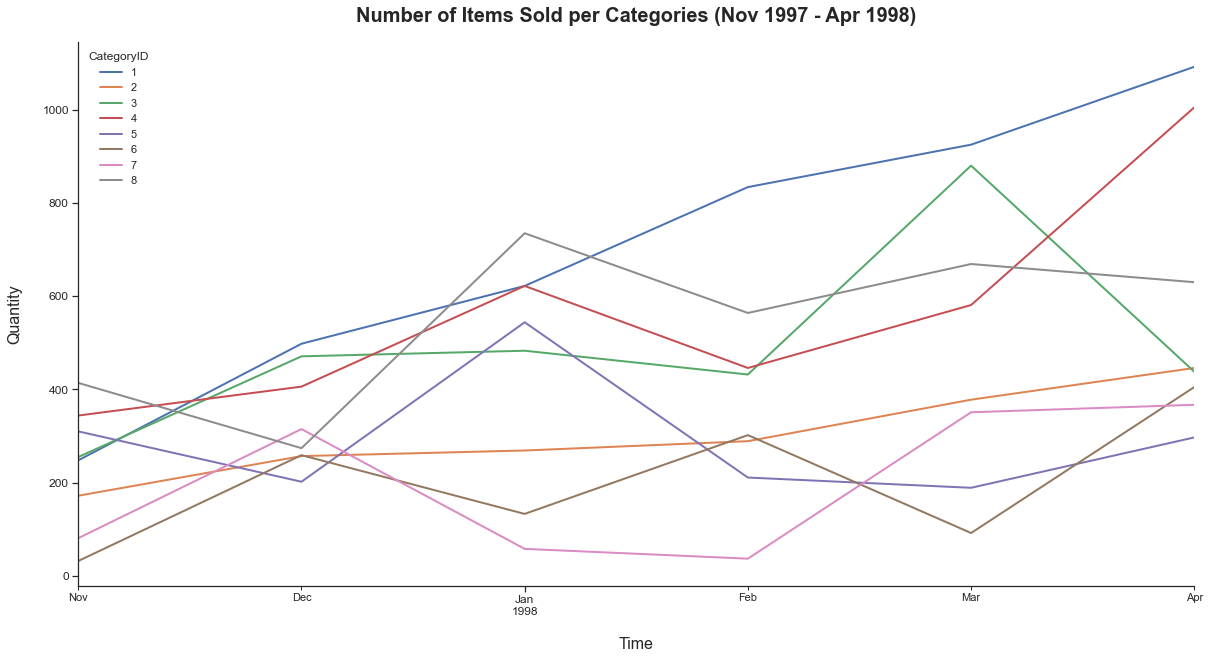

In [52]:
q2c.T.plot(kind='line', linewidth=2.0, figsize = (20, 10))

plt.xlabel('Time', fontsize = 16, labelpad = 20)
plt.ylabel('Quantity', fontsize = 16, labelpad = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.title('Number of Items Sold per Categories (Nov 1997 - Apr 1998)', fontweight = 'bold', fontsize = 20, pad = 20)

plt.show()

In [53]:
dfCategories[['CategoryID', 'CategoryName']]

,CategoryID,CategoryName
0,1,Beverages
1,2,Condiments
2,3,Confections
3,4,Dairy Products
4,5,Grains/Cereals
5,6,Meat/Poultry
6,7,Produce
7,8,Seafood


Category 1 (`Beverages`; blue), Category 4 (`Dairy Products`; red), and Category 8 (`Seafood`; grey) showed a strong uptrend during the period which signaled that demands were rising for those products. Category 3 (`Confections`; green) showed a significant rise at Feb - Mar 1998, but plunged down sharply in April. Category 5 (`Grains/Cereals`; purple) spiked at Jan 1998 As for the remainder of the categories, they were relatively stable and did not see an increase while Northwind's sales were in an uptrend.

**REMARKS**
> - In order to catch up with the momentum, it is highly suggested that Northwind should've kept their supplies checked for both `Beverages` and `Dairy Products`. It was very possible that this rising trend likely to sustain over a period of time, and it was important for Northwind to increase the stock capacity of `Beverages` and `Dairy Products` to fulfill that need
> - This recommendation further supports the fact that both `Beverages` and `Dairy Products` should've been the company's focus, especially with their short-term rising trend at that time
> - The trend of Dairy Products were remarkably sharp, suggesting an a strong increase in demand of those products

### **Most valuable suppliers: Key partners**

The importance of suppliers in the supply chain are often outshone by the other business aspects such as sales, marketing, finance, etc. It is important for the company to know which suppliers are key and should have been a priority to be maintained.

In [54]:
fig = go.Figure()

fig.add_trace(go.Bar(
                     y = q2d['Proportion'],
                     x = q2d.index,
                     text = q2d['Proportion'].apply(lambda x: '{:.2f}%'.format(x)), # Format text label
                     textposition = 'outside', # Set position of text label
                     marker = {'color' : px.colors.qualitative.Prism}))

fig.update_layout(title_text = "Northwind's Supplier Contribution to Total Revenue",
                  height = 700)

fig.update_xaxes(tickangle = -90) # Rotate x axis
fig.update_yaxes(title_text = 'Total revenue proportion (%)')

fig.show()

Norhtwind's top 4 suppliers sorted by their contribution to the inventory value (which could turn into revenue when sold) were `Aux joyeux ecclsiastiques` (12.31%), `Plutzer Lebensmittelgromrkte AG` (11.41%), `Gai pturage` (9.38%), and `Pavlova, Ltd.` (8.54%). These 4 accounts for 41.64% of total inventory value of Northwind.

**REMARKS**
> - Northwind should've put an extra effort to maintain their relationship with `Aux joyeux ecclsiastiques`, `Plutzer Lebensmittelgromrkte AG`, `Gai pturage`, and `Pavlova, Ltd.`. One possible way was to secure a contract with these suppliers such that all of the high-valued item inventories were also secured
> - Northwind could also request a discount since their products were selling a lot and frequently bought in high volumes. Those suppliers also would not want to lose Northwind as a partner

## **Q3. Was there any difference in reorder level between top 25% most sold products and bottom 25% least sold products?**

The idea behind this question is to find out if products that are sold in large quantities (popular) have reorder level that is significantly different from less popular products. Or in other words, can we say with certainty that, on average, popular products also have high reorder level? <br> <br>

To answer that question the author chose to compare the top & bottom 25% products ordered by quantity ordered. First, let's compare their distribution.

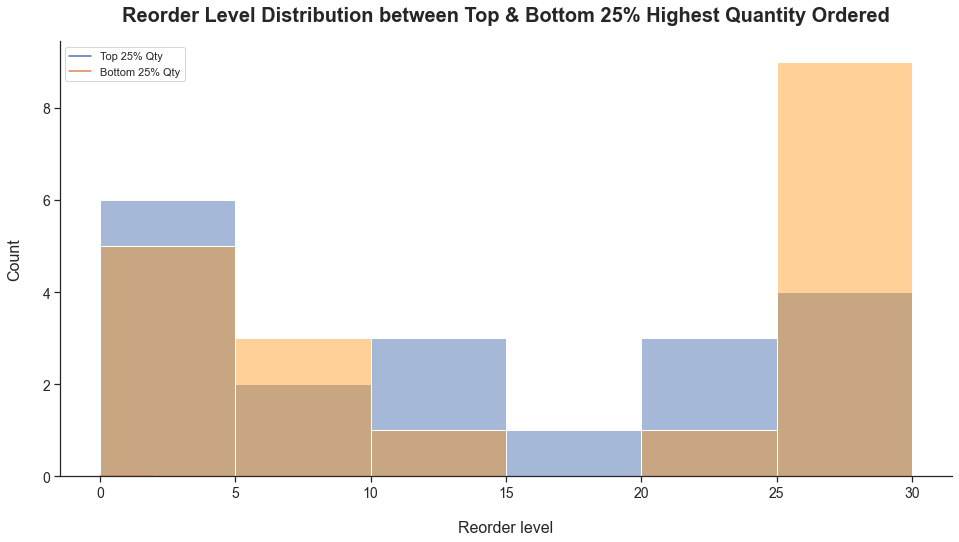

In [55]:
plt.style.use('seaborn-white')
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style = 'ticks', rc = custom_params)
sns.set_palette(sns.color_palette('deep'))

fig, ax = plt.subplots(1, 1, figsize = (16, 8))

sns.histplot(x = q3a['ReorderLevel'], alpha = 0.5, legend=True)
sns.histplot(x = q3b['ReorderLevel'], color = 'darkorange', alpha = 0.4, legend=True)

plt.xlabel('Reorder level', fontsize = 16, labelpad = 20)
plt.ylabel('Count', fontsize = 16, labelpad = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.plot([0, 0], [0, 0], [0, 0, 0])
legend_drawn_flag = True
plt.legend(['Top 25% Qty', 'Bottom 25% Qty'], loc=0, frameon=legend_drawn_flag)

plt.title('Reorder Level Distribution between Top & Bottom 25% Highest Quantity Ordered', fontweight = 'bold', fontsize = 20, pad = 20)

plt.show()

Graphically, the distribution is somewhat similar. But this alone is not enough. We need to perform statistical test to answer the question. Since we are comparing the average 2 independent samples we would use either independent sample t-test or Mann-Whitney U test.

**Data**

In [56]:
q3 = pd.concat([q3a, q3b])
q3.reset_index(drop=True)

,ProductID,ProductName,ReorderLevel,TotalQuantityOrdered,Group
0,60,Camembert Pierrot,0,1577.0,Top 25%
1,59,Raclette Courdavault,0,1496.0,Top 25%
2,31,Gorgonzola Telino,20,1397.0,Top 25%
3,56,Gnocchi di nonna Alice,30,1263.0,Top 25%
4,16,Pavlova,10,1158.0,Top 25%
5,75,Rhnbru Klosterbier,25,1155.0,Top 25%
6,24,Guaran Fantstica,0,1125.0,Top 25%
7,40,Boston Crab Meat,30,1103.0,Top 25%
8,62,Tarte au sucre,0,1083.0,Top 25%
9,2,Chang,25,1057.0,Top 25%


1. Test for normality

In [57]:
# Shapiro-Wilk test
from scipy.stats import shapiro
tstat, pval = shapiro(q3['ReorderLevel'])
print(shapiro(q3['ReorderLevel']))

# Conclusion
if pval < 0.05 :
    print('Reject H0, not normal')
else :
    print('Accept H0, normal')

ShapiroResult(statistic=0.8442363739013672, pvalue=9.553823474561796e-05)
Reject H0, not normal


> Distribution is not normal, we use Mann-Whitney U test

**Hypothesis** <br> <br>
$H_0: \text{Median}_{\text{top,reorder}} = \text{Median}_{\text{bottom,reorder}}$ <br>
$H_1: \text{Median}_{\text{top,reorder}} > \text{Median}_{\text{bottom,reorder}}$ <br>
$\alpha = 0.05$

2. Mann-Whitney U test

In [58]:
from scipy.stats import mannwhitneyu

# 1-tailed
tstat, pval = mannwhitneyu(
						   q3[q3['Group'] == 'Top 25%']['ReorderLevel'],
                           q3[q3['Group'] == 'Bottom 25%']['ReorderLevel'],
						   alternative = 'greater')
print(f'P-value: {pval}')

# Conclusion
if pval < 0.05 :
    print('Reject H0')
else: 
    print('Accept H0')

P-value: 0.8062141147405677
Accept H0


There is not enough evidence (at $\alpha = 5\%$) to say that the median reorder level of the top 25% quantity ordered products was larger than of those at the bottom 25%. The slight difference might be caused due to chance alone. Hence, whether a product belongs to the top 25% or bottom 25% by quantity ordered, it did not have a statistically significant relationship with reorder level.  Or in other words, reorder level cannot be used as a metric of product popularity.

**REMARKS**
> - Reorder level is not a metric of popularity. A high reorder level does not guarantee whether the product is going to sell. Conversely, low reorder level does not guaranteethe product is not going to sell
> - Some of the most popular products actually had low reorder value. This might be caused by a really high volume in low number of orders. The customers order the products in bulk, and hence they only need to order once/twice a year
> - Therefore it was important to view the products in terms of quantities ordered, not reorder value

## **Q4. Who were Northwind's most valuable customers? Was there enough evidence to justify giving them special treatments?**

We want to find who were Northwind's most valuable customers. Maintaining a high value customers are one of the most important thing in business, since their value are essentially limitless, they can contribute a constant cash flow to the company.

In [59]:
fig = go.Figure()

fig.add_trace(go.Bar(
                     y = q4a['TotalRevenue'],
                     x = q4a.index,
                     text = q4a['TotalRevenue'].apply(lambda x: x/1000).apply(lambda x: '{:.2f}k'.format(x)), # Format text label
                     textposition = 'outside', # Set position of text label
                     marker = {'color' : px.colors.qualitative.Vivid},
                     hovertext = q4a['Proportion'].apply(lambda x: '{:.2f}%'.format(x))))

fig.update_layout(title_text = "Northwind's Largest Customers by Country",
                  height = 700)

fig.update_xaxes(tickangle = -90) # Rotate x axis
fig.update_yaxes(title_text = 'Total revenue proportion ($)')

fig.show()

From the graph above, it could be seen that the distribution of Northwind's total revenue by country is largely dominated by the `USA` (19.37%), `Germany` (17.78%), `Austria` (10.35%), `Brazil` (8.54%), and `France` (6.46%). Collectively, these countries alone contributed over 60% of the total revenue generated. Before jumping to any conclusion, let's see the distribution of Northwind's customer lifetime value distribution to complement our analysis **(To view the interactive figure, please open the Tableau file attached in Github)**.

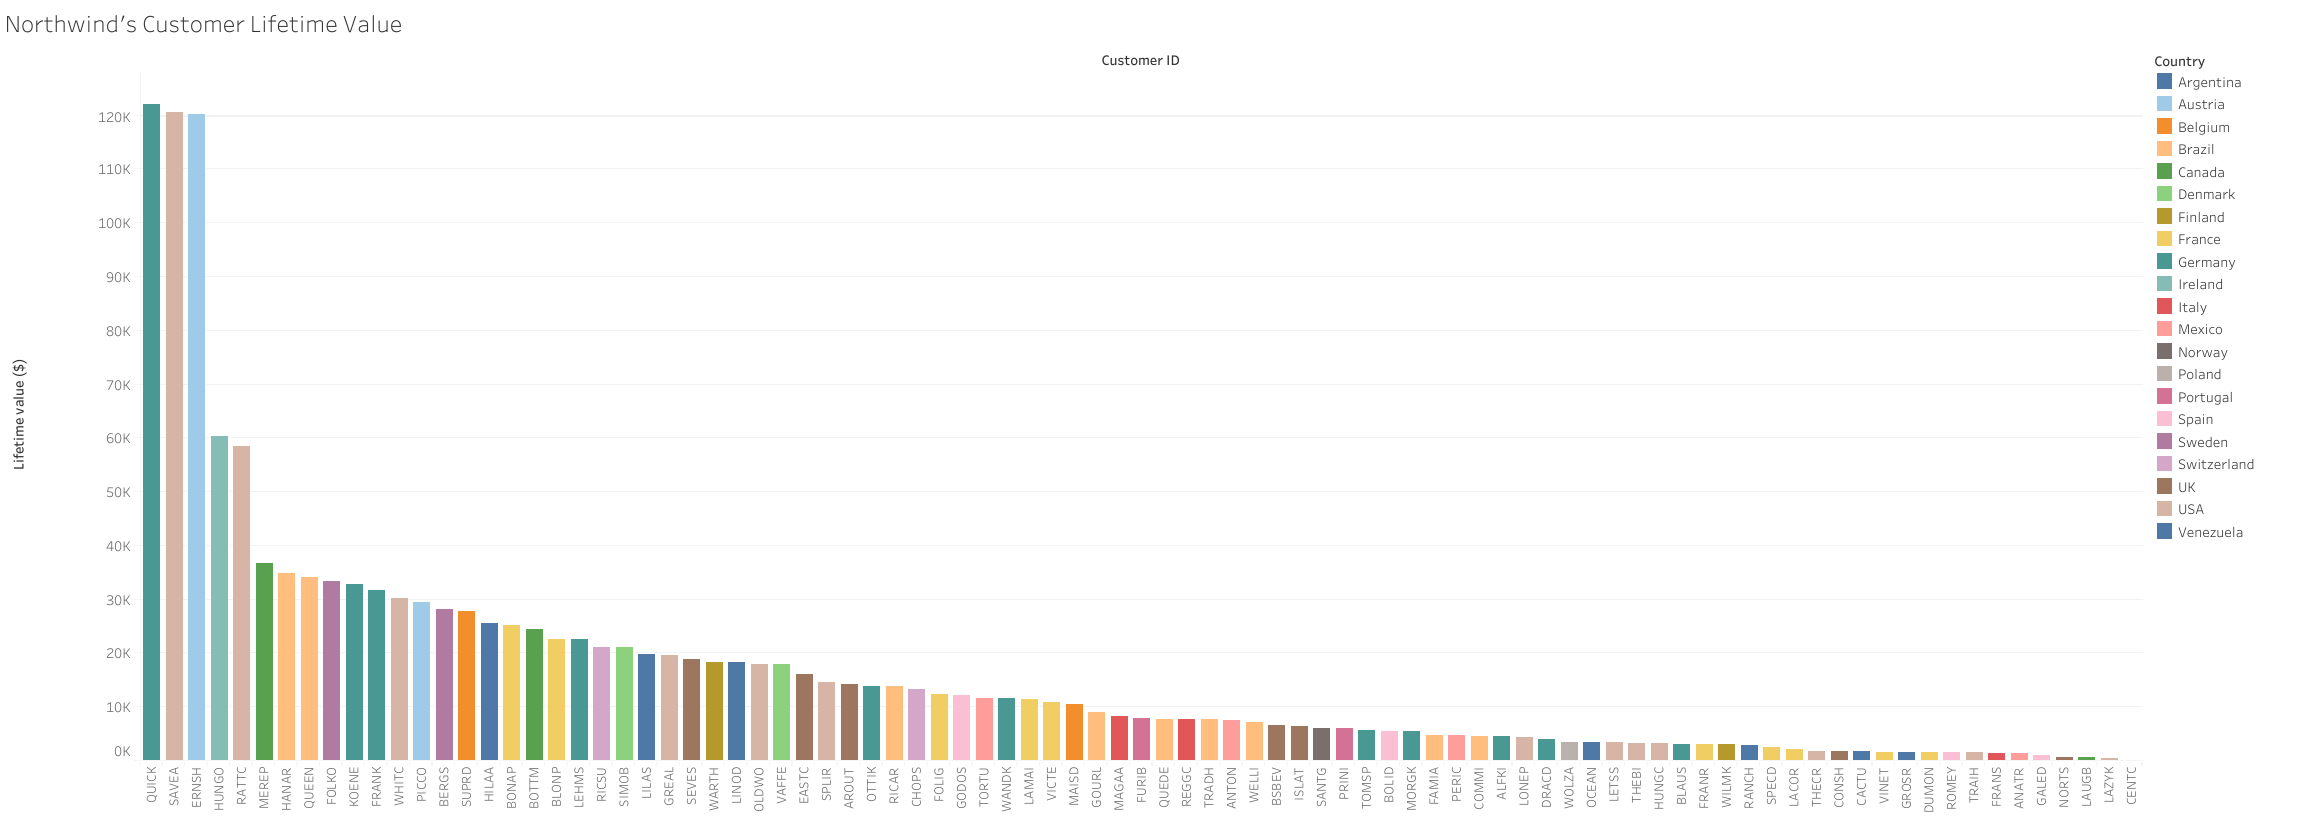

In [60]:
from PIL import Image
image = Image.open("Northwind's Customer Lifetime Value.png")
image

The top 3 customers exceeded the others in terms of lifetime value by a huge margin. They were QUICK-Stop (Germany; 122.2K USD), Save-a-lot Markets (USA; 120.7K USD), and Ernst Handel (Austria; 120.4K USD). All 3 of them accounts for **25% or a 1/4th of the total lifetime value of all customers**.

In [61]:
q4b.reset_index(drop = True).head(18)

,CustomerID,CustomerCompany,Country,LifetimeValue,Proportion,CumulativeSum
0,QUICK,QUICK-Stop,Germany,122199.74,8.43,8.43
1,SAVEA,Save-a-lot Markets,USA,120718.85,8.33,16.76
2,ERNSH,Ernst Handel,Austria,120390.09,8.31,25.07
3,HUNGO,Hungry Owl All-Night Grocers,Ireland,60397.91,4.17,29.24
4,RATTC,Rattlesnake Canyon Grocery,USA,58562.42,4.04,33.28
5,MEREP,Mre Paillarde,Canada,36878.50,2.54,35.82
6,HANAR,Hanari Carnes,Brazil,34916.60,2.41,38.23
7,QUEEN,Queen Cozinha,Brazil,34043.90,2.35,40.58
8,FOLKO,Folk och f HB,Sweden,33477.95,2.31,42.89
9,KOENE,Kniglich Essen,Germany,32902.62,2.27,45.16


However, the author wants to know that if on average the revenue contributed by customers are significantly different from one country to each other, and if it were, which ones are different? By answering this question, the most important countries could be determined as targets for the company's campaign.

To perform this, either 1-way ANOVA or Kruskal-Wallis H test would be used, dependes on the normality assumption. Then, if the averages are different, the appropriate post hoc test would then be conducted.

**Data**

In [62]:
dfComprehensive

,OrderID,CustomerID,CustomerCompany,OrderDate,ShippedDate,RequiredDate,DayDifference,ShipCountry,ShippingCompany,ProductID,ProductName,CategoryID,Quantity,UnitPerQuantity,UnitPrice,Revenue,SupplierID,SupplierName,SupplierCountry,MonthlyOrderDate
0,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,11,Queso Cabrales,4,12,1 kg pkg.,21.00,252.00,5,Cooperativa de Quesos 'Las Cabras',Spain,1996-07
1,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,42,Singaporean Hokkien Fried Mee,5,10,32 - 1 kg pkgs.,14.00,140.00,20,Leka Trading,Singapore,1996-07
2,10248,VINET,Vins et alcools Chevalier,1996-07-04,1996-07-16,1996-08-01,16.0,France,Federal Shipping,72,Mozzarella di Giovanni,4,5,24 - 200 g pkgs.,34.80,174.00,14,Formaggi Fortini s.r.l.,Italy,1996-07
3,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,14,Tofu,7,9,40 - 100 g pkgs.,23.25,209.25,6,Mayumi's,Japan,1996-07
4,10249,TOMSP,Toms Spezialitten,1996-07-05,1996-07-10,1996-08-16,37.0,Germany,Speedy Express,51,Manjimup Dried Apples,7,40,50 - 300 g pkgs.,53.00,2120.00,24,"G'day, Mate",Australia,1996-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,64,Wimmers gute Semmelkndel,5,2,20 bags x 4 pieces,33.25,66.50,12,Plutzer Lebensmittelgromrkte AG,Germany,1998-05
2151,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,66,Louisiana Hot Spiced Okra,2,1,24 - 8 oz jars,17.00,17.00,2,New Orleans Cajun Delights,USA,1998-05
2152,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,73,Rd Kaviar,8,2,24 - 150 g jars,15.00,30.00,17,Svensk Sjfda AB,Sweden,1998-05
2153,11077,RATTC,Rattlesnake Canyon Grocery,1998-05-06,NaT,1998-06-03,NaN,USA,United Package,75,Rhnbru Klosterbier,1,4,24 - 0.5 l bottles,7.75,31.00,12,Plutzer Lebensmittelgromrkte AG,Germany,1998-05


1. Test for normality

In [63]:
# Shapiro-Wilk test
from scipy.stats import shapiro
tstat, pval = shapiro(dfComprehensive['Revenue'])
print(shapiro(dfComprehensive['Revenue']))

# Conclusion
if pval < 0.05 :
    print('Reject H0, not normal')
else :
    print('Accept H0, normal')

ShapiroResult(statistic=0.4717162251472473, pvalue=0.0)
Reject H0, not normal


> Distribution is not normal, we use Kruskal-Wallis H test.

2. Kruskal-Wallis H test

**Hypothesis** <br> <br>
$H_0: \text{Median}_1=\text{Median}_2=...=\text{Median}_k$ <br>
$H_1: \exists \,i,j:\text{Median}_i\neq\text{Median}_j$ <br>
$\alpha = 0.05$

In [64]:
for i in dfComprehensive['ShipCountry'].unique() :
    print(f"dfComprehensive[dfComprehensive['ShipCountry']=='{i}']['Revenue'],")

dfComprehensive[dfComprehensive['ShipCountry']=='France']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Germany']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Brazil']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Belgium']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Switzerland']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Venezuela']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Austria']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Mexico']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='USA']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Sweden']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Finland']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Italy']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='Spain']['Revenue'],
dfComprehensive[dfComprehensive['ShipCountry']=='UK']['Revenue'],
dfComprehensive[d

In [65]:
from scipy.stats import kruskal

tstat, pval = kruskal(
                      dfComprehensive[dfComprehensive['ShipCountry']=='France']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Germany']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Brazil']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Belgium']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Switzerland']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Venezuela']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Austria']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Mexico']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='USA']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Sweden']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Finland']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Italy']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Spain']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='UK']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Ireland']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Portugal']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Canada']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Denmark']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Poland']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Norway']['Revenue'],
                      dfComprehensive[dfComprehensive['ShipCountry']=='Argentina']['Revenue'])
print(f'P-value: {pval}')

# Conclusion
if pval < 0.05 :
    print('Reject H0')
else: 
    print('Accept H0')

P-value: 1.1152673802718933e-23
Reject H0


> There is at least 1 difference in the median of revenue generated from customers from different countries. To check which one is different from each other, post hoc test (Dunn's test) is conducted in the following cell.

3. Dunn's test

**Hypothesis** <br> <br>
$H_0:$ There is no significant difference in revenue generated from customers from different countries <br>
$H_1:$ There is a significant difference in revenue generated from customers from different countries

In [66]:
from scikit_posthocs import posthoc_dunn

pval = posthoc_dunn(a = [dfComprehensive[dfComprehensive['ShipCountry']=='France']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Germany']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Brazil']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Belgium']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Switzerland']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Venezuela']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Austria']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Mexico']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='USA']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Sweden']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Finland']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Italy']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Spain']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='UK']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Ireland']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Portugal']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Canada']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Denmark']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Poland']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Norway']['Revenue'],
                         dfComprehensive[dfComprehensive['ShipCountry']=='Argentina']['Revenue']],
                         p_adjust = 'hommel' )

# Rename column
keys = np.arange(1,22).tolist()
values = dfComprehensive['ShipCountry'].unique().tolist()
dictionary = dict(zip(keys, values))
pval.rename(dictionary, axis = 1, inplace = True)

# Get index
pval['Index'] = dfComprehensive['ShipCountry'].unique().tolist()
pval.set_index('Index')

,France,Germany,Brazil,Belgium,Switzerland,Venezuela,Austria,Mexico,USA,Sweden,Finland,Italy,Spain,UK,Ireland,Portugal,Canada,Denmark,Poland,Norway,Argentina
Index,,,,,,,,,,,,,,,,,,,,,
France,1.000000e+00,0.004734,9.952106e-01,0.923644,0.995211,0.995211,2.563607e-08,9.952106e-01,0.886765,0.995211,0.995211,9.952106e-01,9.418441e-01,9.952106e-01,0.007135,0.995211,0.990524,0.995211,0.995211,0.995211,5.880878e-01
Germany,4.733999e-03,1.000000,2.362424e-02,0.995211,0.995211,0.995211,9.499754e-02,2.761211e-05,0.995211,0.995211,0.171302,2.032732e-03,5.519870e-05,1.622140e-02,0.995211,0.995211,0.995211,0.995211,0.071928,0.858125,1.263783e-04
Brazil,9.952106e-01,0.023624,1.000000e+00,0.995211,0.995211,0.995211,1.644705e-07,8.720778e-01,0.995211,0.995211,0.995211,9.952106e-01,6.177675e-01,9.952106e-01,0.020714,0.995211,0.995211,0.995211,0.995211,0.995211,3.043715e-01
Belgium,9.236442e-01,0.995211,9.952106e-01,1.000000,0.995211,0.995211,9.523090e-01,3.040740e-02,0.995211,0.995211,0.941844,1.360325e-01,1.970760e-02,9.337240e-01,0.995211,0.995211,0.995211,0.995211,0.247230,0.986297,9.595626e-03
Switzerland,9.952106e-01,0.995211,9.952106e-01,0.995211,1.000000,0.995211,8.867655e-01,7.446693e-02,0.995211,0.995211,0.995211,2.545336e-01,4.619718e-02,9.952106e-01,0.995211,0.995211,0.995211,0.995211,0.347353,0.995211,2.099665e-02
Venezuela,9.952106e-01,0.995211,9.952106e-01,0.995211,0.995211,1.000000,2.372672e-03,1.630766e-01,0.995211,0.995211,0.995211,5.994691e-01,1.100598e-01,9.952106e-01,0.593258,0.995211,0.995211,0.995211,0.789663,0.995211,5.480797e-02
Austria,2.563607e-08,0.094998,1.644705e-07,0.952309,0.886765,0.002373,1.000000e+00,3.544695e-10,0.000118,0.004375,0.000064,1.465667e-07,1.710860e-09,2.083588e-07,0.995211,0.167833,0.283864,0.477816,0.000454,0.022197,1.763067e-08
Mexico,9.952106e-01,0.000028,8.720778e-01,0.030407,0.074467,0.163077,3.544695e-10,1.000000e+00,0.008748,0.277131,0.995211,9.952106e-01,9.952106e-01,9.952106e-01,0.000042,0.995211,0.042314,0.344465,0.995211,0.995211,9.952106e-01
USA,8.867655e-01,0.995211,9.952106e-01,0.995211,0.995211,0.995211,1.177372e-04,8.747696e-03,1.000000,0.995211,0.995211,1.232456e-01,8.571742e-03,9.523090e-01,0.510583,0.995211,0.995211,0.995211,0.424657,0.995211,7.350714e-03


In [67]:
dfComprehensive.groupby('ShipCountry')[['Revenue']].median()

,Revenue
ShipCountry,
Argentina,183.690
Austria,735.000
Belgium,456.000
Brazil,315.750
Canada,450.000
Denmark,452.500
Finland,295.500
France,296.250
Germany,520.150


**REMARKS**
> - In general, Northwind could focus on building presence in the top 5 largest countries by revenues: `USA` (19.37%), `Germany` (17.78%), `Austria` (10.35%), `Brazil` (8.54%), and `France` (6.46%). For instance, by building infrastructure and finding key partners in those countries would accelerate the distribution process where transaction volumes were high. Doing this might strengthen the overall supply chain of Northwind
> - Statistically speaking, by using `USA` customers as the benchmark for post hoc analysis, we could find that it had significant difference in median revenue from `Mexico`, `Spain`, and `Argentina`. The median revenue from customers in these countries were statistically lower than the `USA`, so maybe they would be put in a low priority for now. `Austrian` customers had a significantly higher median revenue from the US. This fact further suggested that was important to build presence in `Austria` and start a marketing campaign specific for the country
> - Individual customers with the highest lifetime values were `QUICK-Stop `(Germany; 122.2K USD), `Save-a-lot Markets` (USA; 120.7K USD), and `Ernst Handel` (Austria; 120.4K USD). All 3 of them accounts for 25% or 1/4th of the total lifetime values of all Northwind customers. They also came from the 5 countries mentioned above. All these facts warranted them to get a special treatment from Northwind, maybe in terms of discount or loyalty program to keep their trust to Northwind. Norhtind could also collaborate with them by providing customized products to suit their needs

# **6. CONCLUSION**

1. Northwind's sales performance was overall in a healthy trend (Nov 1997 - Apr 1998) after a period of stagnation
1. Northwind should've played to their strengths: fulfill the market demand of `Beverages`, `Dairy Products`, `Meat/Poultry`, `Confections`, and `Seafood` since each of them comprised > 10% of the total revenue generated
1. Focus company resources on the marketing of the top 15 most valueble products, **especially** `Cte de Blaye`
1. In order to catch up with the momentum, it is highly suggested that Northwind should've kept their supplies checked for both `Beverages` and `Dairy Products`
1. Northwind should've put an extra effort to maintain their relationship with `Aux joyeux ecclsiastiques`, `Plutzer Lebensmittelgromrkte AG`, `Gai pturage`, and `Pavlova, Ltd.`
1. Reorder level is not a metric of popularity. Therefore it was important to view the products in terms of quantities ordered, not reorder value
1. In general, Northwind could focus on building presence in the top 5 largest countries by revenues: `USA`, `Germany`, `Austria`, `Brazil`, and `France`
1. Individual customers with the highest lifetime values were `QUICK-Stop `, `Save-a-lot Markets`, and `Ernst Handel`. They warrant a special treatment from Northwind, maybe in terms of discount or loyalty program to keep their trust to Northwind